# Разработка моделей машинного обучения для принятия решений о приобретении коров по заказу молочного хозяйства

**Цель работы:**<br>
На основании исходных данных с использованием моделей машинного обучения  рекомендовать заказчику приобретение коров, удовлетворяющих его критериям по удою коров и вкусу их молока.

**План работы:**
1. Изучить входные данные, оценить полноту и качество входных данных для достижения цели исследования. Определить задачи предобработки данных.
2. Осуществить предобработку данных в части улучшение качества данных для дальнейшего анализа.
3. Провести исследовательский анализ данных, а также оценить необходимость формирования дополнительных категорий, параметров и групп данных для достижения цели исследования, дополнить ими входные данные.
4. Провести корреляционный анализ данных для оценки взаимосвязи между целевыми и входными признаками.
5. Разработать модель машинного обучения для прогнозирования возможного удоя коров.
6. Разработать модель машинного обучения для прогнозирования вкуса молока коров.
7. Применить разработанные модели машинного на перечне коров поставщика, которые могут быть приобретены.

**Критерии качества**

С помощью моделей необхожимо отобрать коров по двум критериям:
* Средний удой за год — не менее 6000 килограммов,
* Молоко должно быть вкусным.

In [776]:
# Загружаем библиотеки для работы
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
try:
    import missingno as msno
except Exception as e: print(e)  
try:
    import phik as phik
except Exception as e: print(e)  
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 

import itertools as it
from IPython.display import clear_output

In [777]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42

## Шаг 1. Загрузка и изучение входных данных

In [778]:
data_main = pd.read_csv('../../datasets/ferma_main.csv', sep=";")
data_dad = pd.read_csv('../../datasets/ferma_dad.csv', sep=";")
data_buy = pd.read_csv('../../datasets/cow_buy_old.csv', sep=";")

In [779]:
# Изучим общую информацию о данных
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

In [780]:
# Изучим общую информацию о данных
data_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [781]:
# Изучим общую информацию о данных
data_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
dtypes: object(6)
memory usage: 1.1+ KB


На основании общих сведений о входных данных сделаем выводы об их полноте и качестве для целей исследования:
1. Для удобства работы целесообразно привести наименования столбцов всех таблиц к нижнему регистру и представить их на латинице.
2. Очевидных пропусков в таблицах не имеется. При этом, в таблице `data_dad` количество строк меньше, чем в таблице `data_main`. Фактически при объединении таблицы появятся пропуски. Необходима дополнительная проверка.
3. С другой стороны в таблице `data_main` могут быть дубликаты и общее количество коров - 629 ед.
4. Для ряда столбцов выглядят сомнительными их типы данных:
    - `data_main`:
        - ЭКЕ (Энергетическая кормовая единица) - строка;
        - СПО (Сахаро-протеиновое соотношение) - строка;
        - Жирность,% - строка;
        - Белок,% - строка;
        - Возраст - строка;
    - `data_buy`:
        - Текущая_жирность,% - строка;
        - Текущий_уровень_белок,% - строка.
5. В некоторых столбцах могут быть представлены неявные дубликаты:
    - `data_main`:
        - Порода;
        - Тип пастбища;
        - порода папы_быка;
        - Вкус молока;
        - Возраст;
    - `data_dad`:
        - Имя Папы;
    - `data_buy`:
        - Тип пастбища;
        - порода папы_быка;
        - Имя_папы;
        
    Необходима дополнительная проверка.

Изучим несколько строка каждой таблицы

In [782]:
data_main.sample(5)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
352,353,7031,"16,8",2308,"0,95",Вис Бик Айдиал,Холмистое,Айдиал,"3,73","3,08",вкусно,более_2_лет
57,58,6601,"15,7",2097,"0,93",Вис Бик Айдиал,Холмистое,Айдиалл,"3,73","3,081",вкусно,более_2_лет
24,25,5372,"13,2",1703,"0,895",Вис Бик Айдиал,Равнинные,Айдиалл,"3,31","3,078",не вкусно,менее_2_лет
524,525,6975,"15,5",1984,"0,93",РефлешнСоверинг,Холмистое,Айдиал,"3,72","3,075",не вкусно,более_2_лет
283,284,5770,"13,9",1732,"0,88",Вис Бик Айдиал,Холмистое,Соверин,"3,64","3,073",не вкусно,более_2_лет


Дополнительный вывод - в столбце "Возраст" сомнений в типе данных не имеется.

In [783]:
data_dad.sample(5)

,id,Имя Папы
265,266,Буйный
165,166,Соловчик
374,375,Буйный
480,481,Буйный
224,225,Буйный


In [784]:
data_buy.sample(5)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%"
13,Вис Бик Айдиал,холмистое,Соверин,Барин,"3,42","3,075"
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076"
18,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,34","3,069"
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053"
15,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,065"


Построим гистограммы для всех числовых столбцов таблицы `data_main` без дополнительного оформления (только для беглого анализа). В других таблицах параметров с числовими значениями не имеется (кроме `id`). Подробно изучим все данные после их предобработки.

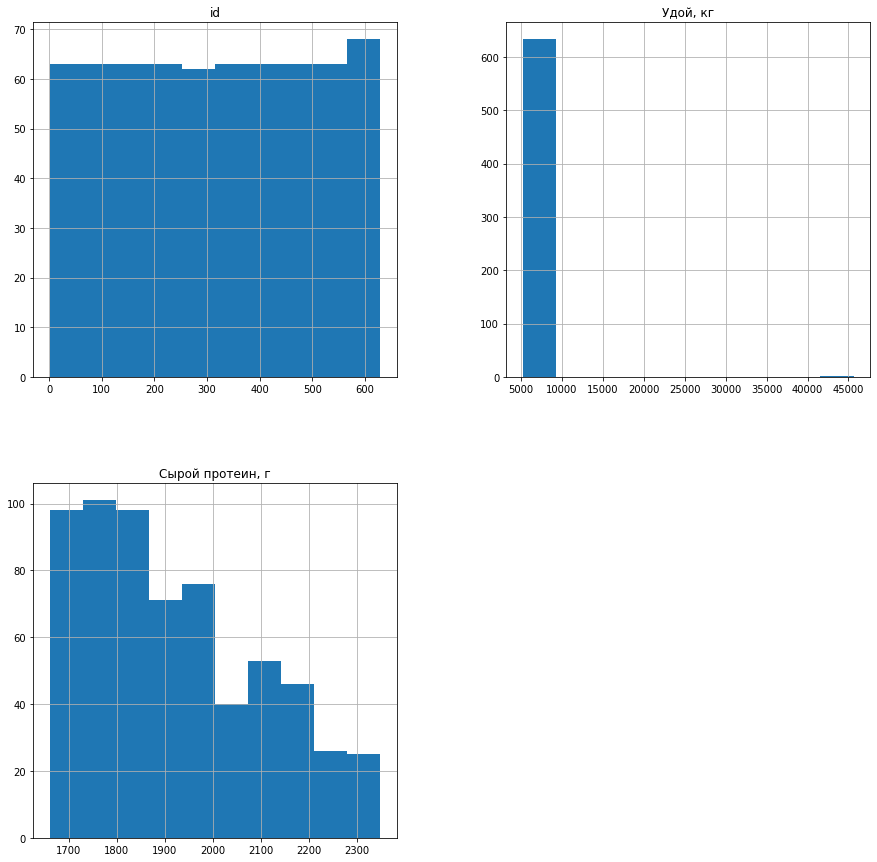

In [785]:
data_main.hist(figsize=(15, 15))
plt.show()

Дополнительный вывод - в столбце "Удой" имеются выбросы, требующие дополнительной проверки.

Создадим функцию, выводящую красивый график (подписанный, с нормальным количеством корзин и гридом) для численных столбцов (int, float, long) наших дата-сетов

In [786]:
def overview_plot(df):
    
    there_is_col = False
    for col in df:
        if df[col].dtype in ['int', 'float', 'long']:
            df[col].plot(kind='hist', bins=30, grid=True, legend=True)
            plt.title('Распределение\nисследуемого параметра\nпо наименованию столбца')
            plt.xlabel('Единицы изменения\nисследуемого параметра')
            plt.ylabel('Частоста повторений\nисследуемого параметра')
            legend = 'Столбец' + ' [' + col + ']'
            plt.legend([legend])
            plt.show()
            there_is_col = True
    if not there_is_col: print('В дата-сете нет численных столбцов')

Применим созданную функцию к входным дата-сетам

In [787]:
overview_plot(data_main)

В дата-сете нет численных столбцов


Дополнительные выводы:
- столбец "id" представляет собой ключевой столбец с равномерно возрастающими номерами коров (от 0 до 600+);
- в столбце "Удой, кг" имеются выбросы, требующие дополнительной проверки;
- по распределению значений столбца "Сырой протеин, г" аномалии не выявлены.

In [788]:
overview_plot(data_dad)

В дата-сете нет численных столбцов


Дополнительный выводы: столбец "id" представляет собой ключевой столбец с равномерно возрастающими номерами коров (от 0 до 600+) - вероятно, такой же, как в основном дата-сете (data_main).

In [789]:
overview_plot(data_buy)

В дата-сете нет численных столбцов


Дополнительный выводы: в дата-сете на данный момент отсутствуют численные столбцы. Будем их анализировать после приведения типовы данных.

## Шаг 2. Предобработка данных

Прозведем предобработку данных на основании ранее сделанных выводов:
1. Приведем наименования столбцов к нижнему регистру и представим латиницей.
2. Изменим типы данных столбцов в соответствии с их содержанием.
3. Обработаем выявленные пропущенные значения.
4. Проверим предположение о наличии неявных дубликатов и обработаем их при необходимости.

Предварительно создадим копии входных данных для дальнейшей работы

In [790]:
c_data_main = data_main.copy()
c_data_dad = data_dad.copy()
c_data_buy = data_buy.copy()

### Обработка наименований столбцов

В ходе первичного ознакомления с данными была выявлена необходимость привести наименования столбцов к нижнему регистру и представить их латиницей.

In [791]:
c_data_main = c_data_main.rename(
    columns = {
        'Удой, кг': 'yield',
        'ЭКЕ (Энергетическая кормовая единица)': 'eke',
        'Сырой протеин, г': 'crude_protein',
        'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
        'Порода': 'breed',
        'Тип пастбища': 'pasture_type',
        'порода папы_быка': 'dad_breed',
        'Жирность,%': 'fat',
        'Белок,%': 'protein',
        'Вкус молока': 'taste',
        'Возраст': 'age'
    }
)

In [792]:
c_data_dad = c_data_dad.rename(
    columns = {
        'Имя Папы': 'dad_name'
    }
)

In [793]:
c_data_buy = c_data_buy.rename(
    columns = {
        'Порода': 'breed',
        'Тип пастбища': 'pasture_type',
        'порода папы_быка': 'dad_breed',
        'Имя_папы': 'dad_name',
        'Текущая_жирность,%': 'fat',
        'Текущий_уровень_белок,%': 'protein',
        'Возраст': 'age'
    }
)

Проверим результаты.

In [794]:
print(c_data_main.info())
print()
print(c_data_dad.info())
print()
print(c_data_buy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   634 non-null    int64 
 1   yield                634 non-null    int64 
 2   eke                  634 non-null    object
 3   crude_protein        634 non-null    int64 
 4   sugar_protein_ratio  634 non-null    object
 5   breed                634 non-null    object
 6   pasture_type         634 non-null    object
 7   dad_breed            634 non-null    object
 8   fat                  634 non-null    object
 9   protein              634 non-null    object
 10  taste                634 non-null    object
 11  age                  634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  -----

Для удобства дальнейшей работы перенесем целевые столбца вправо.

In [795]:
c_data_main = c_data_main[
    [
        'id',
        'eke',
        'crude_protein',
        'sugar_protein_ratio',
        'breed',
        'dad_breed',
        'age',
        'pasture_type',
        'fat',
        'protein',
        'yield',
        'taste'
    ]
]

### Обработка типов данных

В ходе первичного ознакомления с данными была выявлена необходимость изменения типов данных:
- столбцов `data_main`:
    - ЭКЕ (Энергетическая кормовая единица) - строка на float;
    - СПО (Сахаро-протеиновое соотношение) - строка на float;
    - Жирность,% - строка на float;
    - Белок,% - строка на float;
- столбцов `data_buy`:
    - Текущая_жирность,% - строка на float;
    - Текущий_уровень_белок,% - строка на float.

При этом, выявлено, что в ряде строк в указанных столбцах представлены значения в виде строки с символом ','. Для изменения типа данных столбцов на float необходимо заменить символ ',' на точку.

In [796]:
columns_to_change_1 = [
    'eke',
    'sugar_protein_ratio',
    'fat',
    'protein'
]
columns_to_change_2 = [
    'fat',
    'protein'
]

In [797]:
def replace_for_float(df, columns):
    for col in columns:
        df[col] = df[col].str.replace(',', '.')

In [798]:
def change_type(df, columns, new_type):
    if new_type == 'float':
        replace_for_float(df, columns)
    try:
        df[columns] = df[columns].astype(new_type)
    except Exception as e: print(e)
    return df.info()

In [799]:
change_type(c_data_main, columns_to_change_1, 'float')
change_type(c_data_buy, columns_to_change_2, 'float')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   eke                  634 non-null    float64
 2   crude_protein        634 non-null    int64  
 3   sugar_protein_ratio  634 non-null    float64
 4   breed                634 non-null    object 
 5   dad_breed            634 non-null    object 
 6   age                  634 non-null    object 
 7   pasture_type         634 non-null    object 
 8   fat                  634 non-null    float64
 9   protein              634 non-null    float64
 10  yield                634 non-null    int64  
 11  taste                634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column        Non-Null Co

### Обработка дубликатов

В ходе первичного ознакомления с данными было выявлено, что очевидных пропусков в таблицах не имеется. При этом, в таблице `data_dad` количество строк меньше, чем в таблице `data_main`. Фактически при объединении таблицы появятся пропуски. Необходима дополнительная проверка. С другой стороны в таблице `data_main` могут быть дубликаты и общее количество коров - 629 ед.

В связи с этим, предварительно проверим наличие дубликатов в таблицах.

In [800]:
c_data_main.duplicated().sum()

5

In [801]:
c_data_dad.duplicated().sum()

0

In [802]:
c_data_buy.duplicated().sum()

4

В таблицах имеются полные дубликаты. Удалим их.

Проверим количество записей в таблице `data_main`

In [803]:
c_data_main.shape

(634, 12)

In [804]:
c_data_main[c_data_main.duplicated(keep=False)]

,id,eke,crude_protein,sugar_protein_ratio,breed,dad_breed,age,pasture_type,fat,protein,yield,taste
626,627,14.4,1837,0.88,РефлешнСоверинг,Соверин,более_2_лет,Холмистое,3.64,3.075,5970,не вкусно
629,627,14.4,1837,0.88,РефлешнСоверинг,Соверин,более_2_лет,Холмистое,3.64,3.075,5970,не вкусно
630,627,14.4,1837,0.88,РефлешнСоверинг,Соверин,более_2_лет,Холмистое,3.64,3.075,5970,не вкусно
631,627,14.4,1837,0.88,РефлешнСоверинг,Соверин,более_2_лет,Холмистое,3.64,3.075,5970,не вкусно
632,627,14.4,1837,0.88,РефлешнСоверинг,Соверин,более_2_лет,Холмистое,3.64,3.075,5970,не вкусно
633,627,14.4,1837,0.88,РефлешнСоверинг,Соверин,более_2_лет,Холмистое,3.64,3.075,5970,не вкусно


In [805]:
c_data_buy[c_data_buy.duplicated(keep=False)]

,breed,pasture_type,dad_breed,dad_name,fat,protein
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074


Один в один! Удаляем. При этом не забудем убрать `keep = False`

In [806]:
c_data_main = c_data_main.drop_duplicates()
c_data_buy = c_data_buy.drop_duplicates()

Получилось 629 записей. Количество соответствует таблице `data_dad`. _**Остановимся на предположении, что пропусков не имеется.**_

Вместе с тем, количество коров к покупке уменьшилось, так как в таблице имелись дубликаты.

In [807]:
c_data_buy.shape

(16, 6)

Кроме того, проверим наличие неявных дубликатов в различных столбцах, а именно:
- `data_main`:
    - Порода - `breed`;
    - Тип пастбища - `pasture_type`;
    - порода папы_быка - `dad_breed`;
    - Вкус молока - `taste`;
    - Возраст - `age`;
- `data_dad`:
    - Имя Папы - `dad_name`;
- `data_buy`:
    - Порода - `breed`;
    - Тип пастбища - `pasture_type`;
    - порода папы_быка - `dad_breed`;
    - Имя_папы - `dad_name`;

Во-первых, убедимся, что количество записей (id) соответсвует 629 уникальным коровам.

In [808]:
len(c_data_main['id'].unique())

629

In [809]:
len(c_data_dad['id'].unique())

629

Все верно. Совпадение id в различных таблицах проверим позднее. Проверим другие столбцы.

**Столбец `breed` таблицы `data_main`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [810]:
c_data_main['breed'] = c_data_main['breed'].str.lower()
len(c_data_main['breed'].unique())

2

Выведем уникальные значения

In [811]:
c_data_main['breed'].unique()

array(['вис бик айдиал', 'рефлешнсоверинг'], dtype=object)

Всего 2 породы. Оказывается этот признак является бинарным. Учтем эти сведения в дальнейшей работе.

**Столбец `pasture_type` таблицы `data_main`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [812]:
c_data_main['pasture_type'] = c_data_main['pasture_type'].str.lower()
len(c_data_main['pasture_type'].unique())

3

Выведем уникальные значения

In [813]:
c_data_main['pasture_type'].unique()

array(['равнинное', 'равнинные', 'холмистое'], dtype=object)

Среди типов пастбищ также обнаружено только два типа. Рассматриваемый признак бинарный. Однако, в столбце обнаружен неявный дубликат. Исправим это.

In [814]:
c_data_main['pasture_type'] = c_data_main['pasture_type'].str.replace('равнинные', 'равнинное')

Проверим результат

In [815]:
# Unique items
len(c_data_main['pasture_type'].unique())

2

**Столбец `dad_breed` таблицы `data_main`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [816]:
c_data_main['dad_breed'] = c_data_main['dad_breed'].str.lower()
len(c_data_main['dad_breed'].unique())

3

Выведем уникальные значения

In [817]:
c_data_main['dad_breed'].unique()

array(['айдиал', 'соверин', 'айдиалл'], dtype=object)

Среди пород также обнаружены неявные дубликаты, а рассматриваемый признак бинарный. Исправим дубликаты.

In [818]:
c_data_main['dad_breed'] = c_data_main['dad_breed'].str.replace('айдиалл', 'айдиал')

Проверим результат

In [819]:
# Unique items
len(c_data_main['dad_breed'].unique())

2

**Столбец `taste` таблицы `data_main`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [820]:
c_data_main['taste'] = c_data_main['taste'].str.lower()
len(c_data_main['taste'].unique())

2

Выведем уникальные значения

In [821]:
c_data_main['taste'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

Дубликатов не имеется. Признак бинарный

**Столбец `age` таблицы `data_main`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [822]:
c_data_main['age'] = c_data_main['age'].str.lower()
len(c_data_main['age'].unique())

2

Выведем уникальные значения

In [823]:
c_data_main['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

Дубликатов не имеется. Признак бинарный

**Столбец `dad_name` таблицы `data_dad`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [824]:
c_data_dad['dad_name'] = c_data_dad['dad_name'].str.lower()
len(c_data_dad['dad_name'].unique())

4

Выведем уникальные значения

In [825]:
c_data_dad['dad_name'].unique()

array(['буйный', 'соловчик', 'барин', 'геркулес'], dtype=object)

Среди пород не обнаружены неявные дубликаты, рассматриваемый признак мультиклассовый.

**Столбец `breed` таблицы `data_buy`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [826]:
c_data_buy['breed'] = c_data_buy['breed'].str.lower()
len(c_data_buy['breed'].unique())

2

Выведем уникальные значения

In [827]:
c_data_buy['breed'].unique()

array(['вис бик айдиал', 'рефлешнсоверинг'], dtype=object)

Всего 2 породы. Оказывается этот признак является бинарным. Учтем эти сведения в дальнейшей работе.

**Столбец `pasture_type` таблицы `data_buy`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [828]:
c_data_buy['pasture_type'] = c_data_buy['pasture_type'].str.lower()
len(c_data_buy['pasture_type'].unique())

2

Выведем уникальные значения

In [829]:
c_data_buy['pasture_type'].unique()

array(['холмистое', 'равнинное'], dtype=object)

Дубликатов не имеется. Признак бинарный

**Столбец `dad_breed` таблицы `data_buy`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [830]:
c_data_buy['dad_breed'] = c_data_buy['dad_breed'].str.lower()
len(c_data_buy['dad_breed'].unique())

2

Выведем уникальные значения

In [831]:
c_data_buy['dad_breed'].unique()

array(['айдиал', 'соверин'], dtype=object)

Дубликатов не имеется. Признак бинарный

**Столбец `dad_name` таблицы `data_buy`**

Приведем значения столбца к нижнему регистру и проверим количество уникальных записей.

In [832]:
c_data_buy['dad_name'] = c_data_buy['dad_name'].str.lower()
len(c_data_buy['dad_name'].unique())

4

Выведем уникальные значения

In [833]:
c_data_buy['dad_name'].unique()

array(['геркулес', 'буйный', 'барин', 'соловчик'], dtype=object)

Среди пород не обнаружены неявные дубликаты, рассматриваемый признак мультиклассовый.

_**Вывод по подразделу "Обработка дубликатов"**_

_В результате работы выявлены полные дубликаты:_
- _в таблице `data_main` - 5 дубликатов, которые снизили количество записей до количества записей в таблице `data_dad`. Доля дубликатов составила 0,7%, наличие дубликатов не повлияет на результаты работы;_
- _в таблице `data_buy` - 4 дубликата, которые снизили количество коров, доступных к приобретению._

_Кроме того, в данных выявлены неявные **дубликаты, связанные с качеством сбора информации со стороны заказчика:**_
- _в столбце `pasture_type` таблицы `data_main`;_
- _в столбце `dad_breed` таблицы `data_main`._


### Вывод по разделу "Предобработка данных"

В ходе предобработки данных были достигнуты следующие результаты:

1. Не были обнаружены пропущенные значения.

2. Были обнаружены и обработаны полные (9 шт.) и неявные (в 2 столбцах) дубликаты. Причиной появления дубликатов может являться челевеческий фактов, приводящий к появлению полных дубликатов (посчитали нескольких коров несколько раз), а также приводящий к появлению ошибок в заполнении некоторых данных. В частности, ошибке в наименовании породы (неявный дубликат в столбце dad_breed таблицы data_main) и в типе пастбища, который по сути повторяет уже существующий ("Равнинные" при существующем "Равнинное").

3. Изменены типы данных в соответствии с их содержанием в столбцах с численными показателями. Сведения в них были представлены в виде строк с символами, которые не могут быть использованы при анализе и разработке моделей машинного обучения. Причиной появления данных с некорректными типами данных является принцип сбора и сохранения данных со стороны заказчика (использование запятой вместо точки в представлении дробных чисел).

Предобработка данных завершена, данные готовы к дальнейшей очистки и анализу.

## Шаг 3. Исследовательский анализ данных

Проведем исследовательский анализ данных. В ходе анализа постараемся оценить:
1. Распределение элементов дата-сетов (коров) по категориальным признакам, применимость признаков для дальнейшей работы (достаточное распределение элемементов по признакам - репрезентативность).
2. Распределение количественных признаков, в том числе, тип распределений для дальнейшей работы по разработке моделей машинного обучения, наличие выбросов и аномальных значений.

**I.** Для каждого столбцы с категориальными признаками:
1. Построим круговую диаграмму (количество категорий не превышает 4, круговая диграмма подходит).
2. Оценим репрезентативность каждого значения признака.

Исследуемые столбца с количественным параметром:
- таблица `data_main`
    - `breed`
    - `pasture_type`
    - `dad_breed`
    - `taste`
    - `age`
- таблица `data_dad`
    - `dad_name`
- таблица `data_buy`
    - `breed`
    - `pasture_type`
    - `dad_breed`
    - `dad_name`

**II.** Для каждого столбца с количественным параметром:
1. Определим количественные характеристики распределений значений, построим гистрограммы и диаграммы размаха.
2. Определим выбросы. При необходимости более внимательно изучим выбросы в части их влияния на цель исследования и примем решение об их исправлении или удалении.<br>Основным критерием удаления выбросов определим их выход за пределы диаграммы размаха. При количестве строк с аномальными значениями менее 5% выборки, такие строки приоритетны к удалению, но может потребоваться дополнительный анализ.<br>При количестве выбросов более 5% их удаление производить не будем до исследования других параметров. Создадим запрос для использования метода query() в будущем с целью фильтрации данных.
3. После очистки данных изучим их распределение, визуализируем. Сделаем выводы.

Исследуемые столбцы с количественным параметром:
- таблица `data_main`
    - `yield`
    - `eke`
    - `crude_protein`
    - `sugar_protein_ratio`
    - `fat`
    - `protein`
- таблица `data_buy`
    - `fat`
    - `protein`

Создадим вспомогательную функцию, выводящую основные показатели для анализа количественных параметров в соответствии с описанным выше подходом

In [834]:
def my_describe(df, column, desc=['hist', 'QR', 'describe', 'box', 'eject'],
                hist_desc=['Распределение\nисследуемого параметра',
                           'Единицы изменения\nисследуемого параметра',
                           'Частоста повторений\nисследуемого параметра'],
                box_desc=['Диаграмма размаха\nисследуемого параметра',
                           'Наименование\nисследуемого столбца',
                           'Единицы изменения\nисследуемого параметра']):
    
    legend_my_desc = 'Столбец' + ' [' + column + ']'
    
    if 'hist' in desc:
        df[column].plot(kind='hist', bins=30, grid=True, legend=True)
        plt.title(hist_desc[0])
        plt.xlabel(hist_desc[1])
        plt.ylabel(hist_desc[2])
        plt.legend([legend_my_desc])
        plt.show()
        
    quartiles = df[column].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    min_diagramm = max(quartiles[0.25] - 1.5*iqr, df[column].min())
    max_diagramm = min(quartiles[0.75] + 1.5*iqr, df[column].max())  
    
    if 'describe' in desc:
        print()
        print('Ключевые характеристики распределения:')
        print(df[column].describe().apply("{0:.2f}".format))

    if 'QR' in desc:
        print()
        print('Ключевые характеристики диграммы размаха:')
        print('IQR\t\t\t{0:.2f}'.format(iqr))
        print('Q1-1,5*IQR\t\t{0:.2f}'.format(quartiles[0.25] - 1.5*iqr))
        print('MIN диаграммы размаха\t{0:.2f}'.format(min_diagramm))
        print('Q3+1,5*IQR\t\t{0:.2f}'.format(quartiles[0.75] + 1.5*iqr))      
        print('MAX диаграммы размаха\t{0:.2f}'.format(max_diagramm))
        print()
        
    if 'box' in desc:
        df[column].plot(kind='box', grid=True)
        plt.title(box_desc[0])
        plt.xlabel(box_desc[1])
        plt.ylabel(box_desc[2])
        plt.legend([legend_my_desc])
        plt.show()
    
    if 'eject' in desc:
        print('Ключевые характеристики выбросов:')
        print('Количество выбросов (вверх)\t{0:.0f}'
              .format(len(df[df[column] > max_diagramm])))
        print('Доля выбросов (вверх)\t\t{0:.2f}%'
              .format(len(df[df[column] > max_diagramm]) / len(df) * 100))
        print('Количество выбросов (вниз)\t{0:.0f}'
              .format(len(df[df[column] < min_diagramm])))
        print('Доля выбросов (вниз)\t\t{0:.2f}%'
              .format(len(df[df[column] < min_diagramm]) / len(df) * 100))

Создадим вспомогательную функцию, оценивающую нормальность распределения количественной величины

In [835]:
def is_norm(data):
    res = stats.normaltest(data)
    stats.probplot(data, dist='norm', plot=plt)
    plt.show()
    # Коэффициент статистической значимости установим 0.05
    if res.pvalue > 0.05:
        return 'p-value = {}. Имеются основания говорить о нормальности распределения'.format(res.pvalue)
    else:
        return 'p-value = {}. Имеются основания говорить о НЕнормальности распределения'.format(res.pvalue)

Создадим вспомогательную функцию, выводящую результаты анализа для категориальных признаков в соответствии с описанным выше подходом

In [836]:
def category_pie(df, column, pie_desc='Соотношение по исследуеммому признаку'):
    df[column].value_counts().plot(
        kind = 'pie', 
        autopct = '%1.0f%%',
        figsize=(7,7), 
        ylabel = '',
        title = pie_desc)

In [837]:
def categories_pies(df, columns):
    raws_plot = int(round(len(columns)/3, 0))
    fig, axes = plt.subplots(1, len(columns), figsize=(4*len(columns), 6))
    for i in range(0, len(columns)):
        df[columns[i]].value_counts().plot(
            kind = 'pie', 
            autopct = '%1.0f%%',
            ylabel = '',
            title = 'Соотношение\nпо исследуемому признаку\nстолбца "{}"'.format(columns[i]),
            ax = axes[i]
        )

### I. Исследование категориальных признаков

**Столбцы таблицы `data_main`**

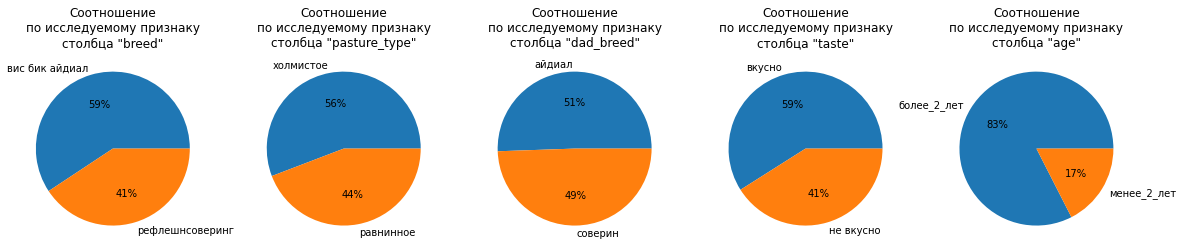

In [838]:
cat_names_main = [
    'breed',
    'pasture_type',
    'dad_breed',
    'taste',
    'age',
]
categories_pies(c_data_main, cat_names_main)

1. Соотношение коров двух различных пород 59% к 41% - достаточно для достижения целей работы.

2. Соотношение коров, пасущихся на двух раззличных типах пастбищ, 56% к 44% - достаточно для достижения целей работы.

3. Соотношение коров с различной породой пап 51% к 49% - достаточно для достижения целей работы.

На основании сведений столбцов `breed` и `dad_breed` можно предположить, что эти столбца полностью повторяют друг другу, так как наименования пород одинаковы. Необходимо дополнительно проверить, может ли быть ситуация когда порода коровы - "айдиал", а порода папы - "соверин", и наоборот.

In [839]:
c_data_main.query('breed == "вис бик айдиал"')['dad_breed'].unique()

array(['айдиал', 'соверин'], dtype=object)

Предположение можно отмести. Указанные столбцы могут быть использованы оба для достижения целей работы.

4. Соотношение коров по вкусу молока 59% к 41% - достаточно для достижения целей работы.

5. *Соотношение коров по возрасту 17% к 83% - может оказаться недостаточно для достижения целей работы. Возможность использования указанного признака необходимо оценить отдельно. Малое количество коров менее 2 лет может сказаться на результатах работы моделей машинного обучения.*

**Столбец `dad_name` таблицы `data_dad`**

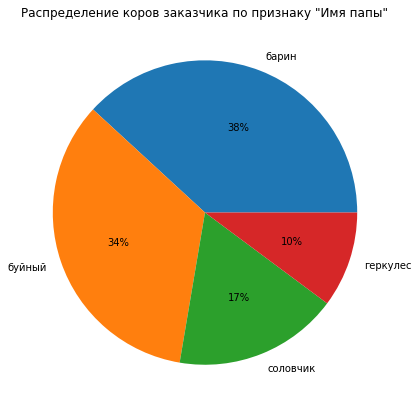

In [840]:
category_pie(c_data_dad, 'dad_name', pie_desc='Распределение коров заказчика по признаку "Имя папы"')

Соотношение коров по имени папы 34:17:38:10. Признак может быть использован для достижения целей работы.

**Столбцы таблицы `data_buy`**

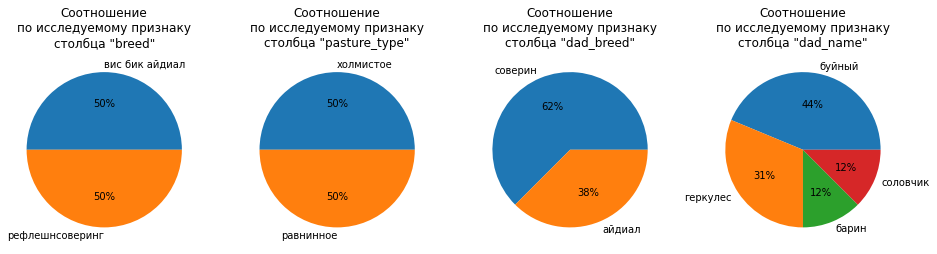

In [841]:
cat_names_buy = [
    'breed',
    'pasture_type',
    'dad_breed',
    'dad_name',
]
categories_pies(c_data_buy, cat_names_buy)

Соотношение коров, доступных к покупке, по признакам не играет роли при обучении моделей. На основании рассматриваемой таблицы будем предсказывать целевые признаки

In [842]:
def create_cat_taste(row):
    if row['taste'] == 'вкусно':
        return 1
    else:
        return 0

In [843]:
c_data_main.loc[:, 'taste'] = c_data_main.apply(create_cat_taste, axis=1)
change_type(c_data_main, ['taste'], 'int')

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   629 non-null    int64  
 1   eke                  629 non-null    float64
 2   crude_protein        629 non-null    int64  
 3   sugar_protein_ratio  629 non-null    float64
 4   breed                629 non-null    object 
 5   dad_breed            629 non-null    object 
 6   age                  629 non-null    object 
 7   pasture_type         629 non-null    object 
 8   fat                  629 non-null    float64
 9   protein              629 non-null    float64
 10  yield                629 non-null    int64  
 11  taste                629 non-null    int32  
dtypes: float64(4), int32(1), int64(3), object(4)
memory usage: 61.4+ KB


### II. Исследование количественных параметров

Исследуем столбцы с количественным параметром:
- таблица `data_main`
    - `yield`
    - `eke`
    - `crude_protein`
    - `sugar_protein_ratio`
    - `fat`
    - `protein`
- таблица `data_buy`
    - `fat`
    - `protein`

In [844]:
def get_math(data):
    return math.log(data)
    # return math.sqrt(data)
    # return data**(1/3)

**Столбец `yield` таблицы `data_main`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции

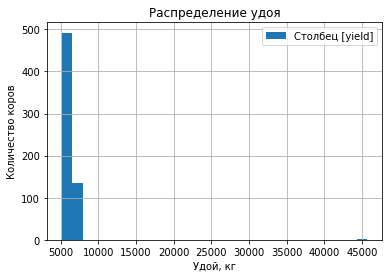


Ключевые характеристики распределения:
count      629.00
mean      6188.75
std       1644.80
min       5204.00
25%       5751.00
50%       6133.00
75%       6501.00
max      45616.00
Name: yield, dtype: object

Ключевые характеристики диграммы размаха:
IQR			750.00
Q1-1,5*IQR		4626.00
MIN диаграммы размаха	5204.00
Q3+1,5*IQR		7626.00
MAX диаграммы размаха	7626.00



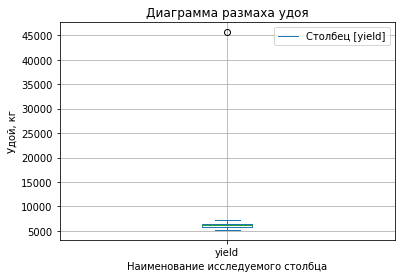

Ключевые характеристики выбросов:
Количество выбросов (вверх)	1
Доля выбросов (вверх)		0.16%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [845]:
my_describe(c_data_main, 'yield',
            hist_desc=['Распределение удоя',
                       'Удой, кг',
                       'Количество коров'],
            box_desc=['Диаграмма размаха удоя',
                      'Наименование исследуемого столбца',
                      'Удой, кг'])

Избавимся от обнаруженного выброса (значение удоя 45616 кг). Удалим эту запись. При этом, удалим запись из таблицы `data_dad` с аналогичным значением поля `id`.

In [846]:
c_data_main[c_data_main['yield'] == 45616]

,id,eke,crude_protein,sugar_protein_ratio,breed,dad_breed,age,pasture_type,fat,protein,yield,taste
16,17,11.5,1675,0.93,вис бик айдиал,айдиал,более_2_лет,холмистое,3.22,3.076,45616,1


In [847]:
c_data_main = c_data_main[c_data_main['yield'] != 45616]
c_data_main

,id,eke,crude_protein,sugar_protein_ratio,breed,dad_breed,age,pasture_type,fat,protein,yield,taste
0,1,14.2,1743,0.890,вис бик айдиал,айдиал,более_2_лет,равнинное,3.58,3.076,5863,1
1,2,12.8,2138,0.890,вис бик айдиал,соверин,менее_2_лет,равнинное,3.54,3.079,5529,1
2,3,14.0,1854,0.885,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.59,3.074,5810,0
3,4,12.4,2012,0.885,рефлешнсоверинг,айдиал,более_2_лет,холмистое,3.40,3.075,5895,0
4,5,12.8,1675,0.885,вис бик айдиал,соверин,менее_2_лет,равнинное,3.73,3.073,5302,1
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,15.4,1964,0.940,рефлешнсоверинг,айдиал,более_2_лет,равнинное,3.74,3.075,6812,0
625,626,12.9,1700,0.880,рефлешнсоверинг,соверин,менее_2_лет,равнинное,3.64,3.073,5513,1
626,627,14.4,1837,0.880,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.64,3.075,5970,0
627,628,13.8,1994,0.890,рефлешнсоверинг,соверин,более_2_лет,равнинное,3.64,3.077,5746,1


In [848]:
c_data_dad = c_data_dad[c_data_dad['id'] != 17]
c_data_dad

,id,dad_name
0,1,буйный
1,2,соловчик
2,3,барин
3,4,буйный
4,5,барин
...,...,...
624,625,буйный
625,626,барин
626,627,барин
627,628,барин


Проверим результат

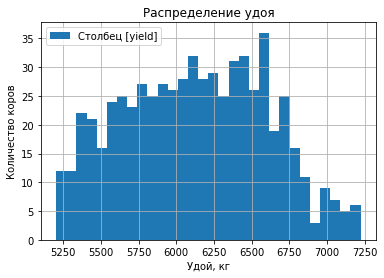


Ключевые характеристики распределения:
count     628.00
mean     6125.97
std       475.86
min      5204.00
25%      5749.75
50%      6132.50
75%      6501.00
max      7222.00
Name: yield, dtype: object


In [849]:
my_describe(c_data_main, 'yield', desc=['hist', 'describe'],
            hist_desc=['Распределение удоя',
                       'Удой, кг',
                       'Количество коров'],
            box_desc=['Диаграмма размаха удоя',
                      'Наименование исследуемого столбца',
                      'Удой, кг'])

Проверим нормальность распределения

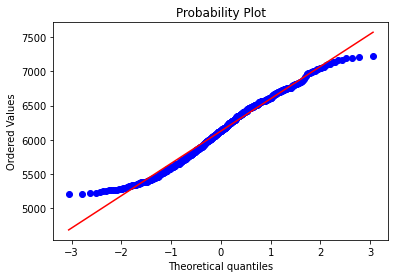

'p-value = 9.40304562689169e-14. Имеются основания говорить о НЕнормальности распределения'

In [850]:
is_norm(c_data_main['yield'])

Визуализируем очищенные данные

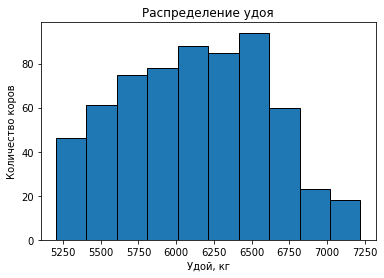

In [851]:
plt.hist(c_data_main['yield'], edgecolor='black', bins=10)
plt.title('Распределение удоя')
plt.xlabel('Удой, кг')
plt.ylabel('Количество коров')
plt.show()

_**Вывод**_

*В результате очистки данных исключен из рассмотрения один выброс. После очистки данных выявлены ключевые характеристики распределения удоя коров:*
* *средний удой и медиана близки - 6125.97 и 6132.50 кг;*
* *удой 50% коров в диапазоне 5749.75 - 6501.00 кг;*
* *минимальный удой - 5204 кг, максимальный - 7222 кг.*

Имеются основания говорить, что распределение параметра **не нормально**.
Имеются основания говорить, что распределение носит характер распределения Пуассона.

**Столбец `eke` таблицы `data_main`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

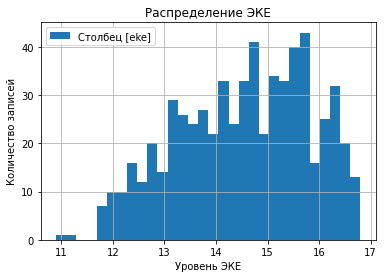


Ключевые характеристики распределения:
count    628.00
mean      14.55
std        1.30
min       10.90
25%       13.50
50%       14.70
75%       15.60
max       16.80
Name: eke, dtype: object

Ключевые характеристики диграммы размаха:
IQR			2.10
Q1-1,5*IQR		10.35
MIN диаграммы размаха	10.90
Q3+1,5*IQR		18.75
MAX диаграммы размаха	16.80



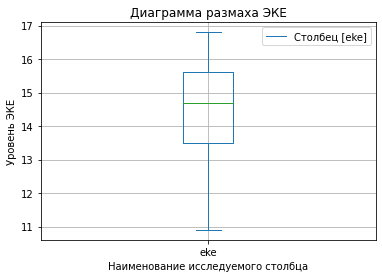

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [852]:
my_describe(c_data_main, 'eke',
            hist_desc=['Распределение ЭКЕ',
                       'Уровень ЭКЕ',
                       'Количество записей'],
            box_desc=['Диаграмма размаха ЭКЕ',
                      'Наименование исследуемого столбца',
                      'Уровень ЭКЕ'])

Проверим нормальность распределения

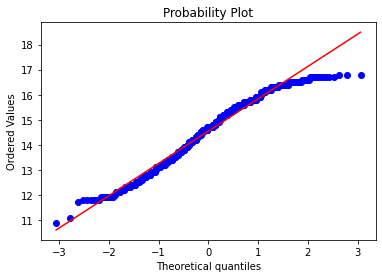

'p-value = 8.055421547425134e-14. Имеются основания говорить о НЕнормальности распределения'

In [853]:
is_norm(c_data_main['eke'])

Визуализируем очищенные данные

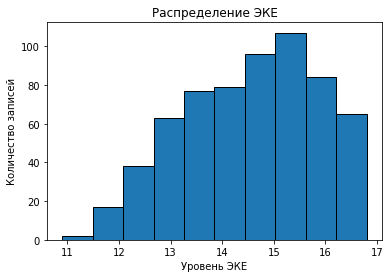

In [854]:
plt.hist(c_data_main['eke'], edgecolor='black', bins=10)
plt.title('Распределение ЭКЕ')
plt.xlabel('Уровень ЭКЕ')
plt.ylabel('Количество записей')
plt.show()

_**Вывод**_

*В результате исследования данных не обнаружено проблем. Выявлены ключевые характеристики распределения показателя ЭКЕ корма коров:*
* *среднее значение и медиана близки - 14.55 и 14.70 ед.;*
* *ЭКЕ корма 50% коров в диапазоне 13.50 - 15.60 ед.;*
* *минимальное значение ЭКЕ - 10.90 ед., максимальное - 16.80 ед.*

Имеются основания говорить, что распределение параметра **не нормально**. 

**Столбец `crude_protein` таблицы `data_main`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

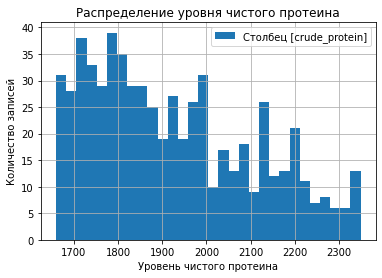


Ключевые характеристики распределения:
count     628.00
mean     1923.76
std       182.83
min      1660.00
25%      1771.75
50%      1888.00
75%      2062.25
max      2349.00
Name: crude_protein, dtype: object

Ключевые характеристики диграммы размаха:
IQR			290.50
Q1-1,5*IQR		1336.00
MIN диаграммы размаха	1660.00
Q3+1,5*IQR		2498.00
MAX диаграммы размаха	2349.00



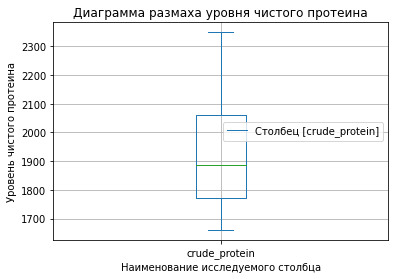

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [855]:
my_describe(c_data_main, 'crude_protein',
            hist_desc=['Распределение уровня чистого протеина',
                       'Уровень чистого протеина',
                       'Количество записей'],
            box_desc=['Диаграмма размаха уровня чистого протеина',
                      'Наименование исследуемого столбца',
                      'Уровень чистого протеина'])

Проверим нормальность распределения

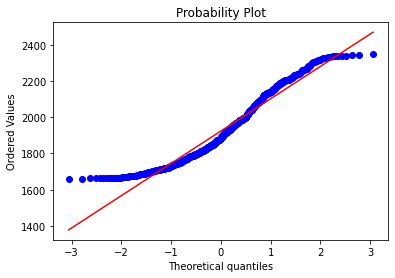

'p-value = 4.3188809922927437e-16. Имеются основания говорить о НЕнормальности распределения'

In [856]:
is_norm(c_data_main['crude_protein'])

Визуализируем очищенные данные

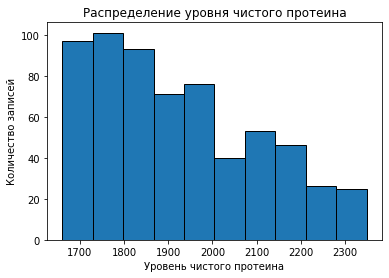

In [857]:
plt.hist(c_data_main['crude_protein'], edgecolor='black', bins=10)
plt.title('Распределение уровня чистого протеина')
plt.xlabel('Уровень чистого протеина')
plt.ylabel('Количество записей')
plt.show()

_**Вывод**_

*В результате исследования данных не обнаружено проблем. Выявлены ключевые характеристики распределения показателя чистого протеина корма коров:*
* *среднее значение и медиана близки - 1923.76 и 1888.00 ед.;*
* *уровень чистого протеина корма 50% коров в диапазоне 1771.75 - 2062.25 ед.;*
* *минимальное значение уровня чистого протеина - 1660.00 ед., максимальное - 2349.00 ед.*

Имеются основания говорить, что распределение параметра **не нормально**. 

**Столбец `sugar_protein_ratio` таблицы `data_main`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции

In [858]:
c_data_main

,id,eke,crude_protein,sugar_protein_ratio,breed,dad_breed,age,pasture_type,fat,protein,yield,taste
0,1,14.2,1743,0.890,вис бик айдиал,айдиал,более_2_лет,равнинное,3.58,3.076,5863,1
1,2,12.8,2138,0.890,вис бик айдиал,соверин,менее_2_лет,равнинное,3.54,3.079,5529,1
2,3,14.0,1854,0.885,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.59,3.074,5810,0
3,4,12.4,2012,0.885,рефлешнсоверинг,айдиал,более_2_лет,холмистое,3.40,3.075,5895,0
4,5,12.8,1675,0.885,вис бик айдиал,соверин,менее_2_лет,равнинное,3.73,3.073,5302,1
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,15.4,1964,0.940,рефлешнсоверинг,айдиал,более_2_лет,равнинное,3.74,3.075,6812,0
625,626,12.9,1700,0.880,рефлешнсоверинг,соверин,менее_2_лет,равнинное,3.64,3.073,5513,1
626,627,14.4,1837,0.880,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.64,3.075,5970,0
627,628,13.8,1994,0.890,рефлешнсоверинг,соверин,более_2_лет,равнинное,3.64,3.077,5746,1


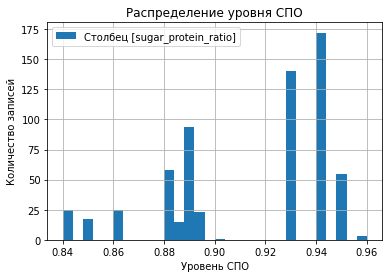


Ключевые характеристики распределения:
count    628.00
mean       0.91
std        0.03
min        0.84
25%        0.89
50%        0.93
75%        0.94
max        0.96
Name: sugar_protein_ratio, dtype: object

Ключевые характеристики диграммы размаха:
IQR			0.05
Q1-1,5*IQR		0.82
MIN диаграммы размаха	0.84
Q3+1,5*IQR		1.01
MAX диаграммы размаха	0.96



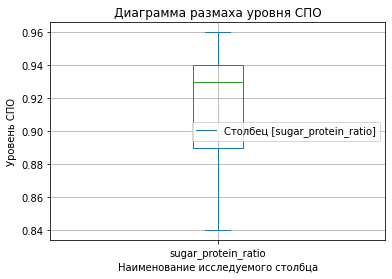

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [859]:
my_describe(c_data_main, 'sugar_protein_ratio',
            hist_desc=['Распределение уровня СПО',
                       'Уровень СПО',
                       'Количество записей'],
            box_desc=['Диаграмма размаха уровня СПО',
                      'Наименование исследуемого столбца',
                      'Уровень СПО'])

Проверим нормальность распределения

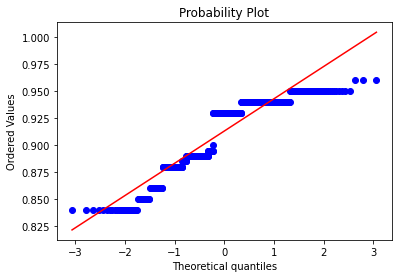

'p-value = 5.150963394084132e-19. Имеются основания говорить о НЕнормальности распределения'

In [860]:
is_norm(c_data_main['sugar_protein_ratio'])

Визуализируем очищенные данные

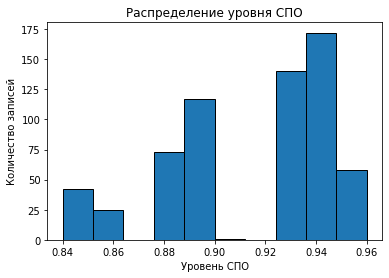

In [861]:
plt.hist(c_data_main['sugar_protein_ratio'], edgecolor='black', bins=10)
plt.title('Распределение уровня СПО')
plt.xlabel('Уровень СПО')
plt.ylabel('Количество записей')
plt.show()

_**Вывод**_

*В результате исследования данных не обнаружено проблем. Выявлены ключевые характеристики распределения показателя СПО корма коров:*
* *среднее значение и медиана близки - 0.91 и 0.93 ед.;*
* *СПО корма 50% коров в диапазоне 0.89 - 0.94 ед.;*
* *минимальное значение СПО - 0.84 ед., максимальное - 0.96 ед.*

Имеются основания говорить, что распределение параметра **не нормально**. 

**Столбец `fat` таблицы `data_main`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

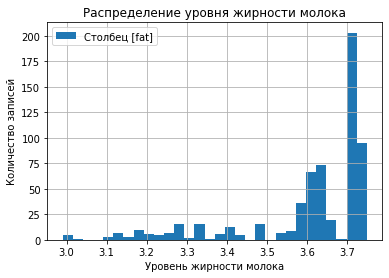


Ключевые характеристики распределения:
count    628.00
mean       3.60
std        0.17
min        2.99
25%        3.59
50%        3.65
75%        3.72
max        3.75
Name: fat, dtype: object

Ключевые характеристики диграммы размаха:
IQR			0.13
Q1-1,5*IQR		3.39
MIN диаграммы размаха	3.39
Q3+1,5*IQR		3.92
MAX диаграммы размаха	3.75



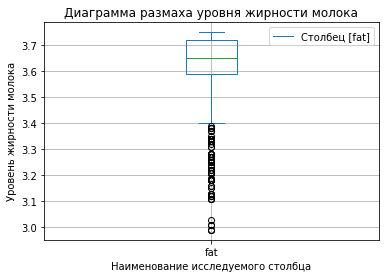

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	86
Доля выбросов (вниз)		13.69%


In [862]:
my_describe(c_data_main, 'fat',
            hist_desc=['Распределение уровня жирности молока',
                       'Уровень жирности молока',
                       'Количество записей'],
            box_desc=['Диаграмма размаха уровня жирности молока',
                      'Наименование исследуемого столбца',
                      'Уровень жирности молока'])

Дополнительно визуализируем QQ-график.

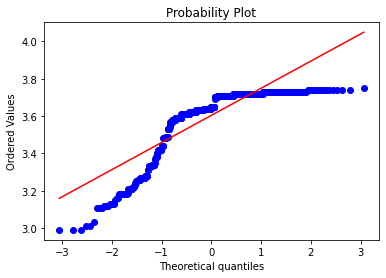

In [863]:
stats.probplot(c_data_main['fat'], dist='norm', plot=plt)
plt.show()

Визуализируем очищенные данные

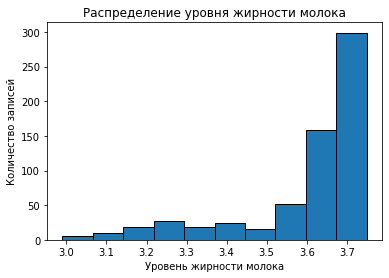

In [864]:
plt.hist(c_data_main['fat'], edgecolor='black', bins=10)
plt.title('Распределение уровня жирности молока')
plt.xlabel('Уровень жирности молока')
plt.ylabel('Количество записей')
plt.show()

_**Вывод**_

*В результате исследования данных не обнаружено проблем. Выявлены ключевые характеристики распределения показателя СПО корма коров:*
* *среднее значение и медиана близки - 0.91 и 0.93 ед.;*
* *СПО корма 50% коров в диапазоне 0.89 - 0.94 ед.;*
* *минимальное значение СПО - 0.84 ед., максимальное - 0.96 ед.*

В рассматриваемом столбце диаграмма размаха показывает большое количество выбросов. В случае удаления указанных выбросов, диаграмма размаха покажет новый уровень, определяющий выбросы. Количество иттераций по очистке данных достигает 3 (только после этого средне и медиана близки друг к другу). После трех удалений выбросов количество данных значительно снижается. _Также мы теряем для анализа и дальнейшего обучения значительное количество показателей признака._

Можно сделать вывод, что применение метода определения выбросов на основе характеристик диаграммы размаха применять в нашем случае нецелесообразно, так как мы теряем много данных.

Предлагается сохранить все значения и оценить их влияние на этапе оценки качества работы модели машинного обучения.

**Столбец `protein` таблицы `data_main`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

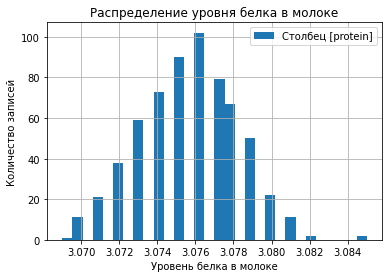


Ключевые характеристики распределения:
count    628.00
mean       3.08
std        0.00
min        3.07
25%        3.07
50%        3.08
75%        3.08
max        3.08
Name: protein, dtype: object

Ключевые характеристики диграммы размаха:
IQR			0.00
Q1-1,5*IQR		3.07
MIN диаграммы размаха	3.07
Q3+1,5*IQR		3.08
MAX диаграммы размаха	3.08



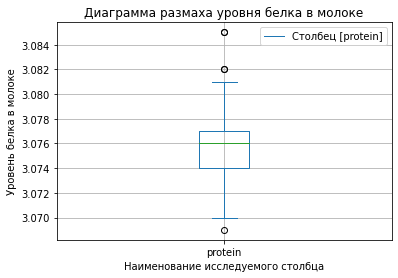

Ключевые характеристики выбросов:
Количество выбросов (вверх)	4
Доля выбросов (вверх)		0.64%
Количество выбросов (вниз)	1
Доля выбросов (вниз)		0.16%


In [865]:
my_describe(c_data_main, 'protein',
            hist_desc=['Распределение уровня белка в молоке',
                       'Уровень белка в молоке',
                       'Количество записей'],
            box_desc=['Диаграмма размаха уровня белка в молоке',
                      'Наименование исследуемого столбца',
                      'Уровень белка в молоке'])

Удалим выбросы.

In [866]:
c_data_main = c_data_main.query('3.07 <= protein <= 3.08')

In [867]:
my_describe(c_data_main, 'protein', desc=['eject', 'describe'])


Ключевые характеристики распределения:
count    612.00
mean       3.08
std        0.00
min        3.07
25%        3.07
50%        3.08
75%        3.08
max        3.08
Name: protein, dtype: object
Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


Дополнительно визуализируем QQ-график.

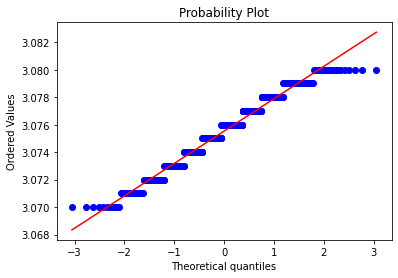

In [868]:
stats.probplot(c_data_main['protein'], dist='norm', plot=plt)
plt.show()

Визуализируем очищенные данные

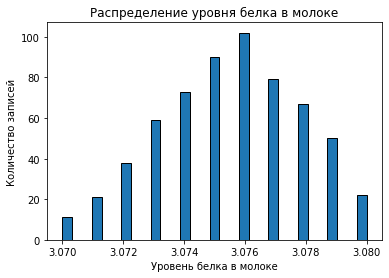

In [869]:
plt.hist(c_data_main['protein'], edgecolor='black', bins=31)
plt.title('Распределение уровня белка в молоке')
plt.xlabel('Уровень белка в молоке')
plt.ylabel('Количество записей')
plt.show()

_**Вывод**_

*В результате исследования данных не обнаружено проблем. Выявлены ключевые характеристики распределения показателя СПО корма коров:*
* *среднее значение и медиана близки - 0.91 и 0.93 ед.;*
* *СПО корма 50% коров в диапазоне 0.89 - 0.94 ед.;*
* *минимальное значение СПО - 0.84 ед., максимальное - 0.96 ед.*

На основании визуализации параметра можно говорить о распределении, как близком к биномиальному распределению.

**Столбец `fat` таблицы `data_buy`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

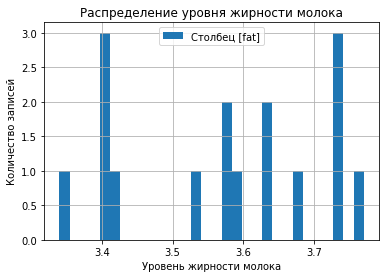


Ключевые характеристики распределения:
count    16.00
mean      3.57
std       0.14
min       3.34
25%       3.42
50%       3.58
75%       3.69
max       3.77
Name: fat, dtype: object


In [870]:
my_describe(c_data_buy, 'fat', desc=['hist', 'describe'],
            hist_desc=['Распределение уровня жирности молока',
                       'Уровень жирности молока',
                       'Количество записей'])

Выбросов не имеется. Оценивать распределение не имеет смысла.

**Столбец `protein` таблицы `data_buy`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

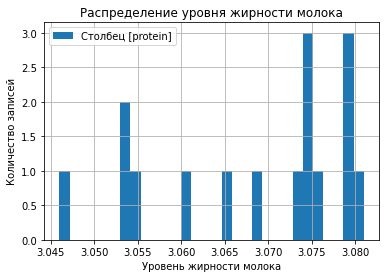


Ключевые характеристики распределения:
count    16.00
mean      3.07
std       0.01
min       3.05
25%       3.06
50%       3.07
75%       3.08
max       3.08
Name: protein, dtype: object


In [871]:
my_describe(c_data_buy, 'protein', desc=['hist', 'describe'],
            hist_desc=['Распределение уровня жирности молока',
                       'Уровень жирности молока',
                       'Количество записей'])

Выбросов не имеется. Оценивать распределение не имеет смысла.

### Вывод по разделу "Исследовательский анализ данных"

В результате проведения исследовательского анализа были выявлены следующие факторы, влияющие на достижение цели работы.
1. В результате исследования категориальных признаков дата-сетов выявлено, в основном, равномерное распределение данных для обучения по бинарным признакам (соотношение около 1:1). 

    Только один признак («возраст») имеет соотношение 2:8, что может оказаться недостаточным для достижения целей работы. Малое количество элементов одного типа может сказаться на результатах работы моделей машинного обучения. _Возможность использования указанного признака для обучения моделей необходимо оценить отдельно._

    Мультиклассовый признак "Имя папы" используем при обучении моделей отдельно.

2. В результате исследования количественных параметров дата-сетов:

    - выявлен выброс в столбце `yield` таблицы `data_main`, в 7 раз превышающий медиану. Выброс удален. В результате анализа имеются основания говорить, что распределение значений в столбце `yield` таблицы `data_main` **не нормально**, а носит характер распределения Пуассона.

    - не обнаружены аномалии в столбцах `eke`, `crude_protein`, `sugar_protein_ratio`, `protein` таблицы `data_main`. В результате анализа имеются основания говорить, что распределение значений в указанных столбцах **не нормальны**.

    - обнаружено большое количество выбросов вниз в столбце `fat` таблицы `data_main`. В случае удаления мы теряем для анализа и дальнейшего обучения значительное количество показателей признака. Предлагается сохранить все значения и оценить их влияние на этапе оценки качества работы модели машинного обучения. В результате анализа имеются основания говорить, что распределение значений в указанных столбцах **не нормальны**.


## Шаг 4. Корреляционный анализ

Корреляционная матрица показывает, что между количественными параметрами отсутсвует линейная связь. Некоторая зависимость (коэффициент корреляции равен 0.5-0.6) имеется между целевыс признаком 'yield' (удой) и входными признакими 'eke' (ЭКЕ), 'sugar_protein_ratio' (СПО) и 'fat' (жирность), меньше (коэффициент - 0.29) - между 'yield' и 'crude_protein'. Логика подсказывает, что жирность зависит от корма (ЭКЕ и СПО), в связи с чем и прослеживается связь удоя и жирности молока. В рамках обучения модели для предсказания удоя мы не будем использовать параметр жирность молока.

Матрица диаграмм рассеяния показывает, что зависимость между 'eke' (ЭКЕ) и 'yield' (удой) нелинейна. Также зависимость 'sugar_protein_ratio' (СПО) и 'yield' (удой), очевидно, нелинейна. Указанные признаки в будущем целесообразно преобразовать для снижения влияния нелинейности.

### Старый вывод по разделу "Корреляционный анализ"

Проведем корреляционный анализ входных и целевых признаков по двум группам, сформированным по целевому признаку:
1. I группа - целевой признак `yield`:
    - входные признаки:
        - `eke` - количественный;
        - `crude_protein` - количественный;
        - `sugar_protein_ratio` - количественный;
        - `breed` - категориальный;
        - `dad_breed` - категориальный;
        - `age` - категориальный;
        - `pasture_type` - категориальный;
        
2. II группа - целевой признак `taste`:
    - входные признаки:
        - `eke` - количественный;
        - `crude_protein` - количественный;
        - `sugar_protein_ratio` - количественный;
        - `fat` - количественный;
        - `protein` - количественный;
        - `breed` - категориальный;
        - `dad_breed` - категориальный;
        - `age` - категориальный;
        - `pasture_type` - категориальный;

Для анализа корреляционных связей построим матрицы корреляции, основанные на коэффициенте корреляции Кендалла (в связи с ненормальностью распределений количественных параметров) для количественных признаков, а также на коэффициенте корреляции Фи, ϕk, для категориальных признаков.

Создадим функцию, формирующую матрицу корреляции

In [872]:
def corr_matrix(df, cols, corr_type, target=None):
    new_cols = list(cols)
    new_cols.append(target)
    if corr_type == 'phik':
        corr = df[new_cols].phik_matrix()
    else:
        corr = df[new_cols].corr(method=corr_type)
    plt.figure(figsize = (10, 5))
    sns.heatmap(corr, vmin=-1, vmax=1,
                cmap='coolwarm', annot=True, fmt='.2f')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title('Матрица корреляции')
    plt.show()

Создадим функцию, отражающую диаграмму рассеяния

In [873]:
def numcat_scatter(df, scatter_type, cols):
    x = cols[0]
    y = cols[1]
    try:
        h = cols[2]
    except:
        h = None
    if scatter_type == 'cat':
        try:
            sns.catplot(data=df, x=x, y=y, hue=h, height=3, aspect=3) 
            plt.title('Распределение признака "{}"\nпо категориям "{}"'.format(x, y))
            plt.xlabel('Признак "{}"'.format(x))
            plt.ylabel('Категория "{}"'.format(y))
            plt.show()
        except Exception as e: print(e)
    elif scatter_type == 'num':
        plt.figure(figsize=(11, 6))
        plt.scatter(x=df[x], y=df[y])
        plt.title('Распределение признака "{}"\nв зависимости от "{}"'.format(x, y))
        plt.xlabel('Признак "{}"'.format(x))
        plt.ylabel('Признак "{}"'.format(y))
        plt.show()
    else:
        print('Wrong scatter_type')

**I группа**

Построим матрици корреляции между количественными и категориальными признаками.

In [874]:
corr_num_columns = [
    'eke',
    'crude_protein',
    'sugar_protein_ratio',
]
corr_cat_columns = [
    'breed',
    'dad_breed',
    'age',
    'pasture_type',
]
target = 'yield'

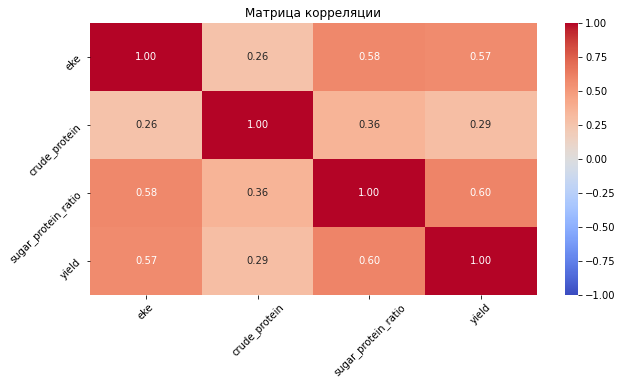

In [875]:
corr_matrix(c_data_main, corr_num_columns, 'kendall', target='yield')

interval columns not set, guessing: ['yield']


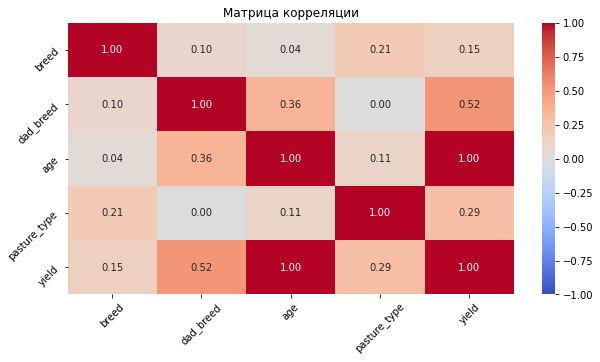

In [876]:
corr_matrix(c_data_main, corr_cat_columns, 'phik', target='yield')

Сильной линейной связи (коэффициент корреляции от 0.9 и выше) между входными признаками (мультиколлениарности) не обнаружено.

Рассмотрим влияние входных признаков на целевой признак

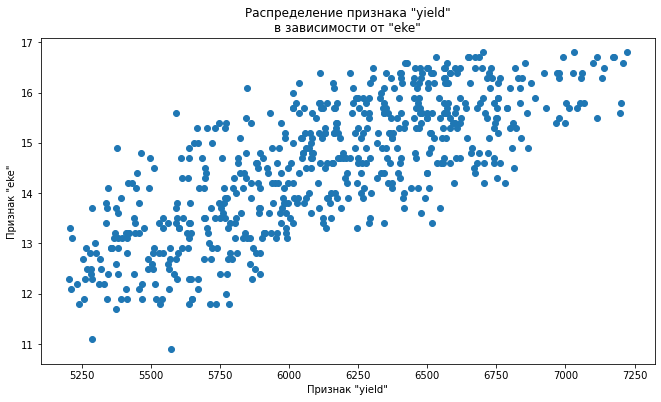

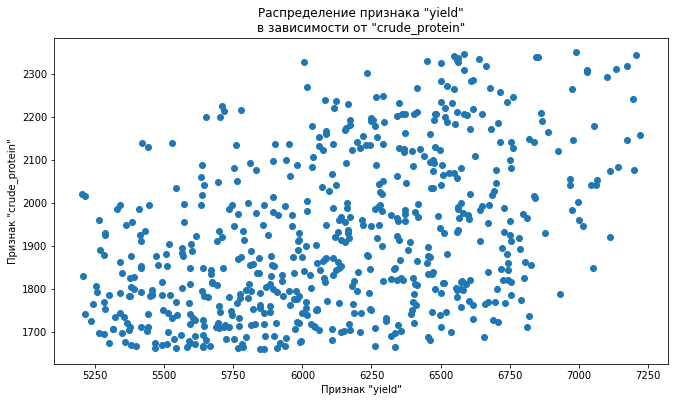

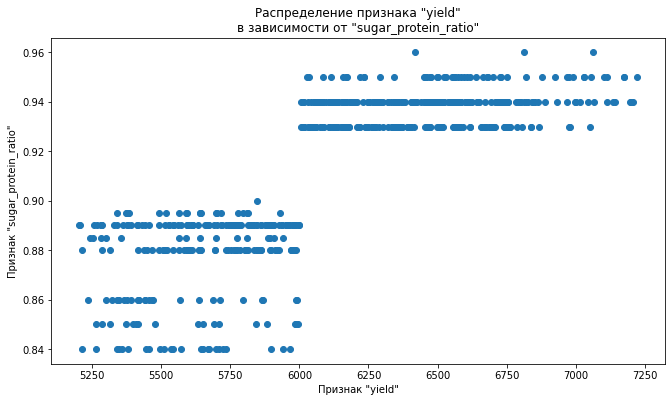

In [877]:
for item in corr_num_columns:
    numcat_scatter(c_data_main, 'num', cols=[target,item])

Линейной связи между входными и целевым признаком не обнаружено. При обучении модели линеной регрессии предлагается исключить представенную нелинейность. В частности, признак `eke` возмести в квадрат, а признак `sugar_protein_ratio` может преобразовать в категориальный.

c:\users\алексей\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


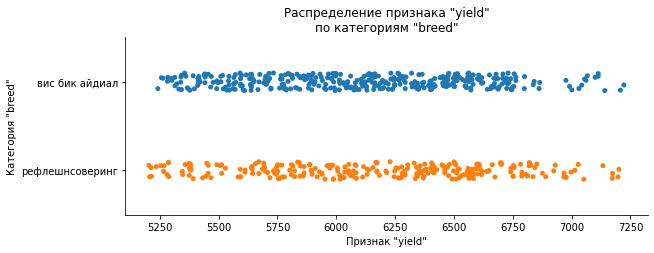

c:\users\алексей\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


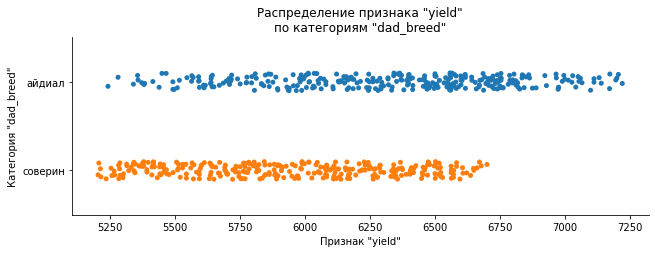

c:\users\алексей\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


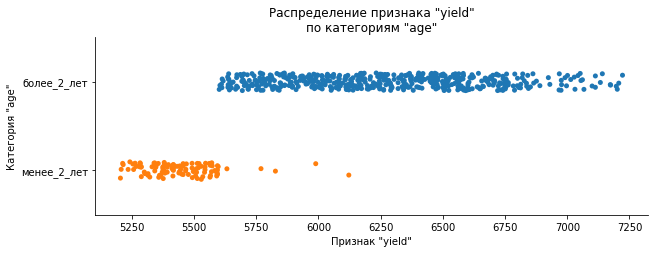

c:\users\алексей\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


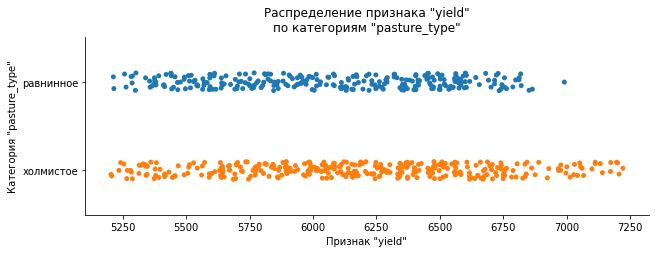

In [878]:
for item in corr_cat_columns:
    numcat_scatter(c_data_main, 'cat', cols=[target,item])

Выявлено сильное влияние признака `age` на целевой признак. Удой коров в возрасте более 2 лет всегда больше ~5600, в то время как удой коров в возрасте менее 2 лет меньше ~5600 (за исключением единичных случаев).

**II группа**

Построим матрици корреляции между количественными и категориальными признаками.

In [879]:
corr_num_columns = [
    'eke',
    'crude_protein',
    'sugar_protein_ratio',
    'fat',
    'protein',    
]
corr_cat_columns = [
    'breed',
    'dad_breed',
    'age',
    'pasture_type',
]
target = 'taste'

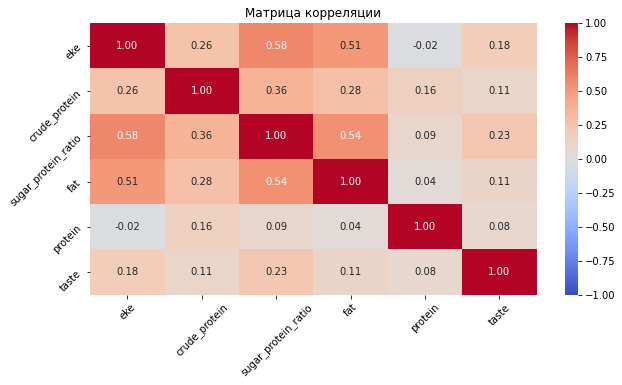

In [880]:
corr_matrix(c_data_main, corr_num_columns, 'kendall', target=target)

interval columns not set, guessing: ['taste']


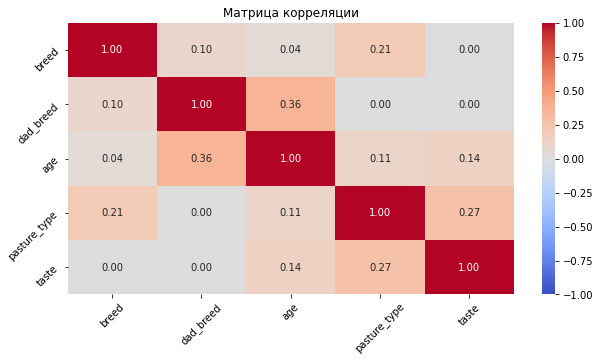

In [881]:
corr_matrix(c_data_main, corr_cat_columns, 'phik', target=target)

Сильной линейной связи (коэффициент корреляции от 0.9 и выше) между входными признаками (мультиколлениарности) не обнаружено.

Вместе с тем, отсутствует корреляция категориальных входных признаков `breed` и `dad_breed` на целевой признак.

Рассмотрим влияние входных категориальных признаков на целевой признак

c:\users\алексей\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


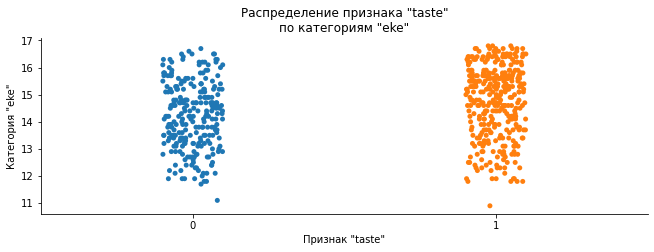

c:\users\алексей\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


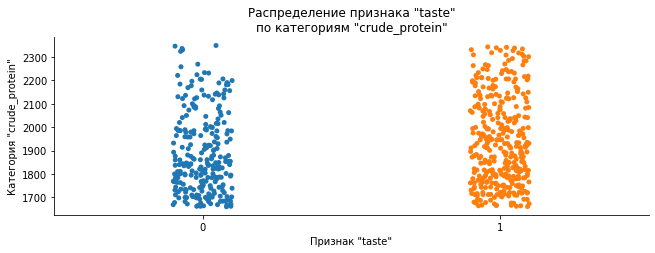

c:\users\алексей\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


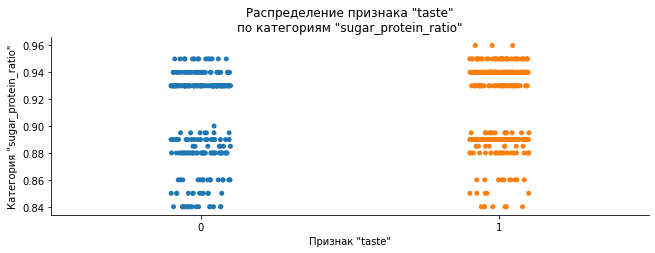

c:\users\алексей\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


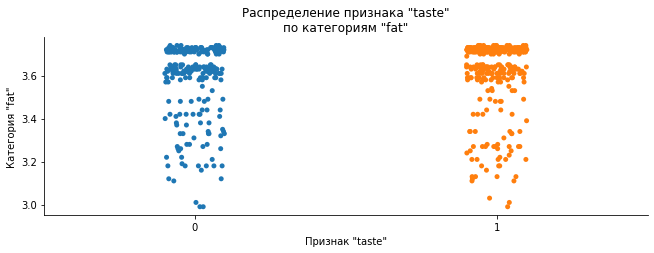

c:\users\алексей\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


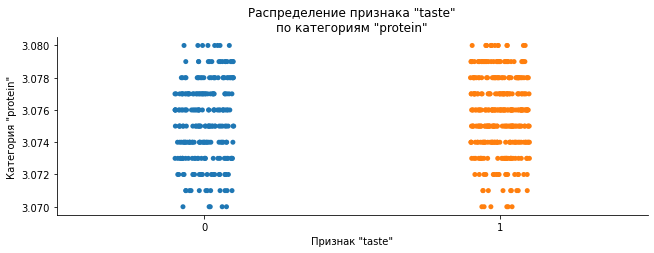

In [882]:
for item in corr_num_columns:
    numcat_scatter(c_data_main, 'cat', cols=[target, item])

Cильного влияния количественных входных признаков не выявлено.

### Новый вывод по разделу "Корреляционный анализ"

В результате проведения корреляционного анализа выявлены следующие факторы, влияющие на результат работы.

1. I группа - целевой признак `yield`:
    1. Сильной линейной связи (коэффициент корреляции от 0.9 и выше) между входными признаками (мультиколлениарности) не обнаружено.
    2. Линейной связи между входными и целевым признаком не обнаружено. При обучении модели линеной регрессии предлагается исключить представенную нелинейность. В частности, признак eke возмести в квадрат, а признак sugar_protein_ratio может преобразовать в категориальный.
    3. Выявлено сильное влияние признака age на целевой признак. Удой коров в возрасте более 2 лет всегда больше ~5600, в то время как удой коров в возрасте менее 2 лет меньше ~5600 (за исключением единичных случаев).
        
2. II группа - целевой признак `taste`:
    1. Сильной линейной связи (коэффициент корреляции от 0.9 и выше) между входными признаками (мультиколлениарности) не обнаружено. Вместе с тем, отсутствует корреляция категориальных входных признаков breed и dad_breed на целевой признак.
    2. Cильного влияния количественных входных признаков не выявлено.

## Шаг 5. Обучение модели линейной регрессии

Для удобства дальнейшей работы сбросим индексы дата-сета

In [883]:
c_data_main = c_data_main.reset_index(drop=True)
c_data_main

,id,eke,crude_protein,sugar_protein_ratio,breed,dad_breed,age,pasture_type,fat,protein,yield,taste
0,1,14.2,1743,0.890,вис бик айдиал,айдиал,более_2_лет,равнинное,3.58,3.076,5863,1
1,2,12.8,2138,0.890,вис бик айдиал,соверин,менее_2_лет,равнинное,3.54,3.079,5529,1
2,3,14.0,1854,0.885,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.59,3.074,5810,0
3,4,12.4,2012,0.885,рефлешнсоверинг,айдиал,более_2_лет,холмистое,3.40,3.075,5895,0
4,5,12.8,1675,0.885,вис бик айдиал,соверин,менее_2_лет,равнинное,3.73,3.073,5302,1
...,...,...,...,...,...,...,...,...,...,...,...,...
607,625,15.4,1964,0.940,рефлешнсоверинг,айдиал,более_2_лет,равнинное,3.74,3.075,6812,0
608,626,12.9,1700,0.880,рефлешнсоверинг,соверин,менее_2_лет,равнинное,3.64,3.073,5513,1
609,627,14.4,1837,0.880,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.64,3.075,5970,0
610,628,13.8,1994,0.890,рефлешнсоверинг,соверин,более_2_лет,равнинное,3.64,3.077,5746,1


В целях прогнозирования удоя коров из всего набора факторов выберем признаки, которые могут оказывать влияние на указанный параметр.

В первую очередь, предполагаем, что удой зависит от **корма коров**, влиящего на их продуктивность:

- Энергетическая кормовая единица (ЭКЕ) - это показатель, который используется для измерения питательности корма коровы. Он основан на количестве энергии, которую содержит корм, и его способности поддерживать рост и продуктивность животного. Влияет на удой.

- Сырой протеин - это один из основных компонентов корма, который важен для роста и развития животных. Он представляет собой количество белка, которое содержится в корме. Влияет на удой.

- Сахаро-протеиновое соотношение - это соотношение между количеством потребляемых углеводов и белков, которое влияет на обмен веществ и общее состояние организма. Влияет на удой.

Кроме того, влиять на удой может наследственность, то есть **признаки "Порода" и "Порода папы"** также может оказывать влияние.

И наконец, **тип пастбища** также влияет на продуктивность коров, поскльку, если мы знаем, что на лугу с большим количеством травы и низким количеством камней корова съела больше корма, то мы можем предположить, что урожай на этом лугу будет выше.

В то же время, логично было бы использовать признак "Возраст", однако в перечне коров, доступных к приобретению, указанный признак не учитывается. Его использование не улучшит нашу модель

Создадим фунцию моделирования линейной регрессии и пустые массивы результатов моделирования.

In [884]:
# Деление дата-сета на выборки для обучения
def prepare_split(df, goal, num_col_names, cat_col_names, val=False):
    
    columns_for_model = num_col_names + cat_col_names
    
    X = df[columns_for_model]
    y = df[goal]
    
    if not val:
        # Разобьем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=0.2,
            random_state=RANDOM_STATE
        )
        return X_train, X_test, y_train, y_test
    else:
        train = 0.6
        test = 0.2
        val = 0.2
        # Разобьем данные на обучающую, тестовую и валидационную выборки
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=0.2,
            random_state=RANDOM_STATE
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, 
            y_train, 
            test_size=0.2,
            random_state=RANDOM_STATE
        )
        return X_train, X_test, y_train, y_test, X_val, y_val

In [885]:
# Нормализация категориальных признаков
def prepare_data(X_train, X_test, cat_col_names, num_col_names):
    
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    
    # Нормализуем категориальные признаки
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    encoder_col_names = encoder.get_feature_names_out()
    
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    # Масштабируем количественные признаки
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    # объединяем все преобразованные данные в тренировочный и тестовый датафреймы
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)  
    
    return X_train, X_test, encoder, scaler

In [886]:
def get_metrics(y_test, predictions, model_type):

    if model_type == 'linear':
        # Рассчитываем метрики на тестовых данных
        mae = mean_absolute_error(y_test, predictions) 
        mse = mean_squared_error(y_test, predictions) 
        rmse = mean_squared_error(y_test, predictions, squared=False)
        # Рассчитывем R2
        r2_lr = r2_score(y_test, predictions) 

        # Проведем анализ остатков
        residuals = y_test - predictions
        
        metrics = {
            'mae': mae,
            'mse': mse, 
            'rmse': rmse, 
            'r2_lr': r2_lr, 
        }
        return metrics, residuals
    
    elif model_type == 'logistic':
        cm = confusion_matrix(y_test, predictions)

        acc = accuracy_score(y_test, predictions)
        recall = recall_score(
            y_test, 
            predictions
        )
        precision = precision_score(
            y_test, 
            predictions
        )
        
        return cm, acc, recall, precision

In [887]:
def print_linear_metrics(metrics, predictions, residuals):

    print('MAE = {0:.0f}'.format(metrics['mae']))
    print('MSE = {0:.0f}'.format(metrics['mse']))
    print('RMSE = {0:.0f}'.format(metrics['rmse']))
    print("R2 LinearRegression =", metrics['r2_lr'])

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    axes[0].hist(residuals, bins=15)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

In [888]:
def print_logostic_metrics(cm, acc, recall, precision):

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r').set(xlabel='Предсказанный вкус', ylabel='Реальный вкус')
    print('acc: ', round(acc, 3))
    print('precision: ', round(precision, 3))
    print('recall: ', round(recall, 3))

In [889]:
# Обучение модели линейной регрессии
def model_lr(df, goal, num_col_names, cat_col_names, out='print'):
    
    X_train, X_test, y_train, y_test = prepare_split(df, goal, num_col_names, cat_col_names, val=False)

    X_train, X_test, encoder, scaler = prepare_data(X_train, X_test, cat_col_names, num_col_names)
    
    # Обучаем инициализируйте модель линейной регрессии
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)

    if out == 'print':
        metrics, residuals = (
            get_metrics(y_test, predictions, model_type='linear')
        )
        print_linear_metrics(metrics, predictions, residuals)
        return metrics, residuals, predictions
    elif out == 'model':
        return encoder, scaler, model_lr

In [890]:
# Создадим пустые массивы
metrics = {}
residuals = {}
predictions = {}
num_col_names = {}
cat_col_names = {}

### Первичное моделирование

Создадим первую модель с указанными признаками.

MAE = 194
MSE = 62000
RMSE = 249
R2 LinearRegression = 0.7492649405446945


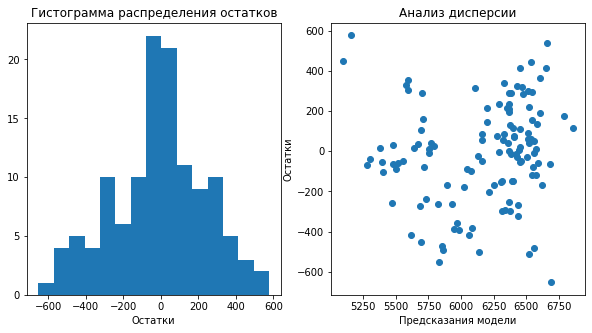

In [891]:
# Имя модели для записи метрик
num_col_names['first'] = [
    'eke',
    'crude_protein',
    'sugar_protein_ratio'
]

cat_col_names['first'] = [
    'breed',
    'dad_breed',
    'pasture_type'
]

metrics['first'], residuals['first'], predictions['first'] = model_lr(
    c_data_main,
    goal='yield',
    num_col_names = num_col_names['first'],
    cat_col_names = cat_col_names['first']
)

### Промежуточный вывод

Коэффициент детерминации построенной модели равен 0.77, следовательно, в 77% случаев предсказание модели ближе к истине, чем среднее значение целевого признака. 
В то же время, анализ остатков показывет, что нарушается свойство постоянства дисперсии, то модель в работе использовать нежелательно, её нужно улучшить.

Предлагается исключить нелинейность зависимости входных параметров и целевого признака, выявленную ранее.

### Устраняем нелинейность № 1

Графики показывают, что СПО и Удой связаны нелинейно. Исключим нелинейность - переведем СПО в категориальный признак, выявив и использовав границу нелинейности. Для этого построим гистограмму и визуально оценим границы признака СПО.

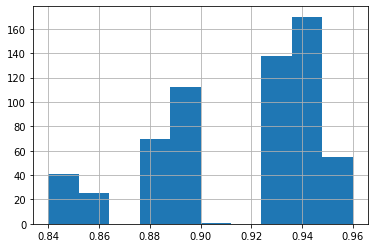

In [892]:
c_data_main['sugar_protein_ratio'].hist()
plt.show()

Вспомним влияние СПО на удой

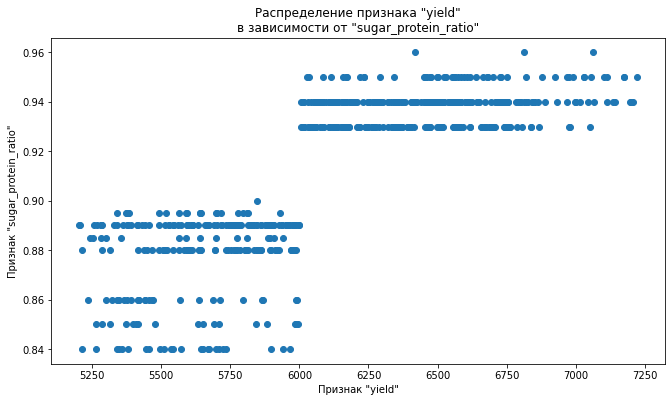

In [893]:
numcat_scatter(c_data_main, 'num', cols=['yield','sugar_protein_ratio'])

Создадим функцию, переводящую количественный признак в категориальный и применим функцию на столбце дата-сета

In [894]:
def create_cat_col(row):
    if row['sugar_protein_ratio'] <= 0.91:
        return 0.
    else:
        return 1.

In [895]:
c_data_main.loc[:, 'sugar_protein_ratio_category'] = c_data_main.apply(create_cat_col, axis=1)
c_data_main

,id,eke,crude_protein,sugar_protein_ratio,breed,dad_breed,age,pasture_type,fat,protein,yield,taste,sugar_protein_ratio_category
0,1,14.2,1743,0.890,вис бик айдиал,айдиал,более_2_лет,равнинное,3.58,3.076,5863,1,0.0
1,2,12.8,2138,0.890,вис бик айдиал,соверин,менее_2_лет,равнинное,3.54,3.079,5529,1,0.0
2,3,14.0,1854,0.885,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.59,3.074,5810,0,0.0
3,4,12.4,2012,0.885,рефлешнсоверинг,айдиал,более_2_лет,холмистое,3.40,3.075,5895,0,0.0
4,5,12.8,1675,0.885,вис бик айдиал,соверин,менее_2_лет,равнинное,3.73,3.073,5302,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,625,15.4,1964,0.940,рефлешнсоверинг,айдиал,более_2_лет,равнинное,3.74,3.075,6812,0,1.0
608,626,12.9,1700,0.880,рефлешнсоверинг,соверин,менее_2_лет,равнинное,3.64,3.073,5513,1,0.0
609,627,14.4,1837,0.880,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.64,3.075,5970,0,0.0
610,628,13.8,1994,0.890,рефлешнсоверинг,соверин,более_2_лет,равнинное,3.64,3.077,5746,1,0.0


Обучим модель с новым столбцом

MAE = 179
MSE = 50584
RMSE = 225
R2 LinearRegression = 0.7954330124007242


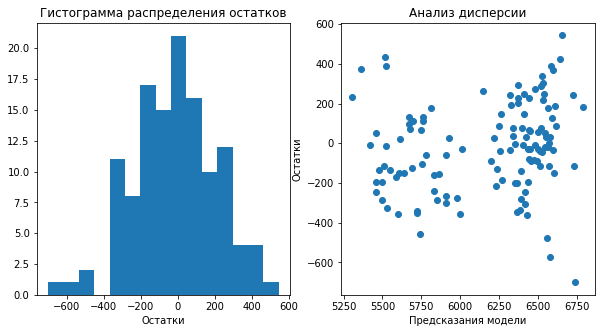

In [896]:
num_col_names['second'] = list(num_col_names['first'])

try:
    num_col_names['second'].remove('sugar_protein_ratio')
except Exception as e: print(e)
    
cat_col_names['second'] = list(cat_col_names['first'])
cat_col_names['second'].append('sugar_protein_ratio_category')

metrics['second'], residuals['second'], predictions['second'] = model_lr(
    c_data_main,
    goal='yield',
    num_col_names = num_col_names['second'],
    cat_col_names = cat_col_names['second']
)

### Промежуточный вывод

Коэффициент детерминации построенной модели равен уже 0.81, следовательно, в 81% случаев предсказание модели ближе к истине, чем среднее значение целевого признака. 
В то же время, анализ остатков показывет, что дисперсия немного изменилась, но далека от идеала.

Продолжим улучшение модели.

### Устраняем нелинейность № 2

ЭКЕ и Удой также связаны нелинейно. Исключим нелинейность вводом нового признака «ЭКЕ в квадрате»

In [897]:
c_data_main.loc[:, 'eke_power'] = c_data_main['eke'] ** 2
c_data_main

,id,eke,crude_protein,sugar_protein_ratio,breed,dad_breed,age,pasture_type,fat,protein,yield,taste,sugar_protein_ratio_category,eke_power
0,1,14.2,1743,0.890,вис бик айдиал,айдиал,более_2_лет,равнинное,3.58,3.076,5863,1,0.0,201.64
1,2,12.8,2138,0.890,вис бик айдиал,соверин,менее_2_лет,равнинное,3.54,3.079,5529,1,0.0,163.84
2,3,14.0,1854,0.885,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.59,3.074,5810,0,0.0,196.00
3,4,12.4,2012,0.885,рефлешнсоверинг,айдиал,более_2_лет,холмистое,3.40,3.075,5895,0,0.0,153.76
4,5,12.8,1675,0.885,вис бик айдиал,соверин,менее_2_лет,равнинное,3.73,3.073,5302,1,0.0,163.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,625,15.4,1964,0.940,рефлешнсоверинг,айдиал,более_2_лет,равнинное,3.74,3.075,6812,0,1.0,237.16
608,626,12.9,1700,0.880,рефлешнсоверинг,соверин,менее_2_лет,равнинное,3.64,3.073,5513,1,0.0,166.41
609,627,14.4,1837,0.880,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.64,3.075,5970,0,0.0,207.36
610,628,13.8,1994,0.890,рефлешнсоверинг,соверин,более_2_лет,равнинное,3.64,3.077,5746,1,0.0,190.44


Обучим модель

MAE = 180
MSE = 50635
RMSE = 225
R2 LinearRegression = 0.7952279356811316


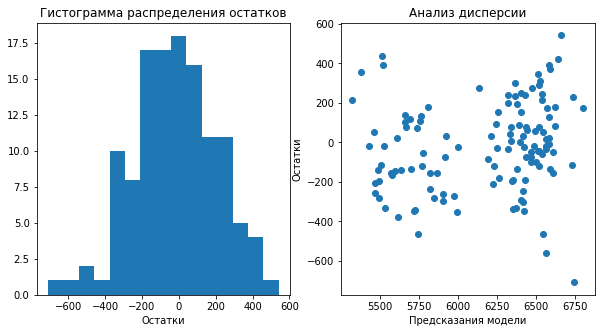

In [898]:
num_col_names['third'] = list(num_col_names['second'])
try:
    num_col_names['third'].remove('eke')
except Exception as e: print(e)
num_col_names['third'].append('eke_power')

cat_col_names['third'] = list(cat_col_names['second'])

metrics['third'], residuals['third'], predictions['third'] = model_lr(
    c_data_main,
    goal='yield',
    num_col_names = num_col_names['third'],
    cat_col_names = cat_col_names['third']
)

### Промежуточный вывод

Коэффициент детерминации построенной незначительно ухудшился! 

Попробуем еще доработать модель.

### Добавляем новый признак

Построим модель с учётом нового признака из таблицы `data_dad`.

In [899]:
c_data_main = (
    c_data_main
    .merge(c_data_dad, how='left', on='id')
)
c_data_main

,id,eke,crude_protein,sugar_protein_ratio,breed,dad_breed,age,pasture_type,fat,protein,yield,taste,sugar_protein_ratio_category,eke_power,dad_name
0,1,14.2,1743,0.890,вис бик айдиал,айдиал,более_2_лет,равнинное,3.58,3.076,5863,1,0.0,201.64,буйный
1,2,12.8,2138,0.890,вис бик айдиал,соверин,менее_2_лет,равнинное,3.54,3.079,5529,1,0.0,163.84,соловчик
2,3,14.0,1854,0.885,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.59,3.074,5810,0,0.0,196.00,барин
3,4,12.4,2012,0.885,рефлешнсоверинг,айдиал,более_2_лет,холмистое,3.40,3.075,5895,0,0.0,153.76,буйный
4,5,12.8,1675,0.885,вис бик айдиал,соверин,менее_2_лет,равнинное,3.73,3.073,5302,1,0.0,163.84,барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,625,15.4,1964,0.940,рефлешнсоверинг,айдиал,более_2_лет,равнинное,3.74,3.075,6812,0,1.0,237.16,буйный
608,626,12.9,1700,0.880,рефлешнсоверинг,соверин,менее_2_лет,равнинное,3.64,3.073,5513,1,0.0,166.41,барин
609,627,14.4,1837,0.880,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.64,3.075,5970,0,0.0,207.36,барин
610,628,13.8,1994,0.890,рефлешнсоверинг,соверин,более_2_лет,равнинное,3.64,3.077,5746,1,0.0,190.44,барин


Обучим модель

MAE = 167
MSE = 44602
RMSE = 211
R2 LinearRegression = 0.8196235687815089


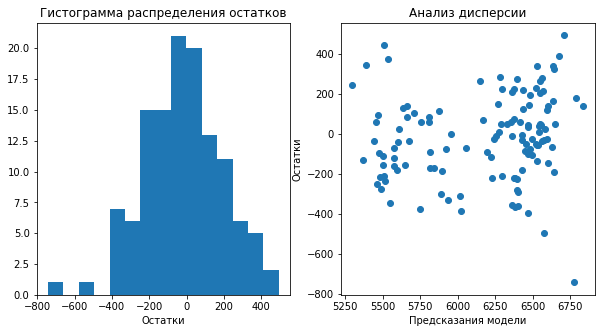

In [900]:
num_col_names['fourth'] = list(num_col_names['third'])


cat_col_names['fourth'] = list(cat_col_names['third'])
cat_col_names['fourth'].append('dad_name')


metrics['fourth'], residuals['fourth'], predictions['fourth'] = model_lr(
    c_data_main,
    goal='yield',
    num_col_names = num_col_names['fourth'],
    cat_col_names = cat_col_names['fourth']
)

### Промежуточный вывод

Коэффициент детерминации улучшился и достиг значения 0.83. 
В то же время, анализ остатков показывет, что дисперсия также улучшилась, но непостоянна.

### Сравнение моделей

Проведем анализ показателей метрик для всех обученных моделей. Сведем все метрики, остатки и предсказания в единые таблицы. Построим графики и сделаем выводы.

In [901]:
df_metrics = pd.DataFrame(metrics).apply(lambda x: np.round(x, decimals=2))
df_metrics

,first,second,third,fourth
mae,193.71,178.53,179.71,166.82
mse,62000.19,50584.04,50634.75,44602.35
rmse,249.00,224.91,225.02,211.19
r2_lr,0.75,0.80,0.80,0.82


In [902]:
df_residuals = pd.DataFrame(residuals)
df_residuals

,first,second,third,fourth
81,-53.976762,-114.884597,-121.776939,-132.727218
218,282.383047,220.310205,213.950651,202.599624
55,-414.568753,-266.823613,-261.312314,-34.934356
600,-30.545378,-83.853177,-73.357102,-102.890168
264,-415.211173,-324.394854,-331.742383,-344.174582
...,...,...,...,...
530,-0.574174,-91.023480,-101.231605,-99.682030
529,7.433257,29.117141,33.614001,74.450634
118,235.421914,228.756592,235.143616,225.830521
79,-150.144391,-196.066769,-190.487130,72.430048


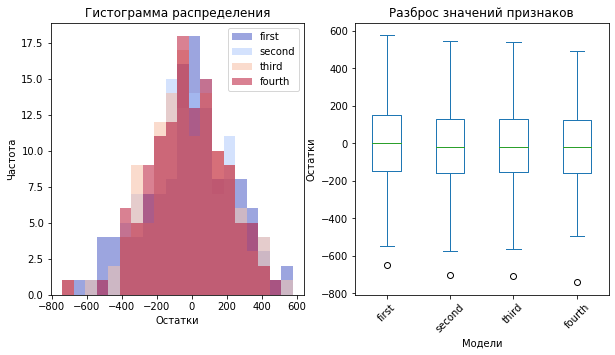

-------

Распределение остатков модели "first"

Ключевые характеристики распределения:
count     123.00
mean       -8.64
std       249.87
min      -652.58
25%      -150.95
50%        -0.57
75%       151.58
max       576.44
Name: first, dtype: object
-------

Распределение остатков модели "second"

Ключевые характеристики распределения:
count     123.00
mean      -19.92
std       224.94
min      -701.34
25%      -157.88
50%       -18.02
75%       128.62
max       543.74
Name: second, dtype: object
-------

Распределение остатков модели "third"

Ключевые характеристики распределения:
count     123.00
mean      -20.17
std       225.03
min      -709.45
25%      -155.97
50%       -21.68
75%       130.79
max       541.65
Name: third, dtype: object
-------

Распределение остатков модели "fourth"

Ключевые характеристики распределения:
count     123.00
mean      -17.47
std       211.33
min      -741.85
25%      -158.38
50%       -23.15
75%       121.44
max       492.93
Name: fourth, dtype: obj

In [903]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

df_residuals.plot(kind='hist', bins=20, ax=axes[0], alpha=0.5, cmap='coolwarm')
axes[0].set_title('Гистограмма распределения')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частота')
df_residuals.plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
axes[1].set_xlabel('Модели')
axes[1].set_ylabel('Остатки')

plt.show()

for item in df_residuals:
    print('-------')
    print()
    print('Распределение остатков модели "{}"'.format(item))
    my_describe(df_residuals, item, desc=['describe'])

In [904]:
df_predictions = pd.DataFrame(predictions)
df_predictions

,first,second,third,fourth
0,6451.976762,6512.884597,6519.776939,6530.727218
1,6472.616953,6534.689795,6541.049349,6552.400376
2,6057.568753,5909.823613,5904.312314,5677.934356
3,6425.545378,6478.853177,6468.357102,6497.890168
4,5619.211173,5528.394854,5535.742383,5548.174582
...,...,...,...,...
118,6368.574174,6459.023480,6469.231605,6467.682030
119,6444.566743,6422.882859,6418.385999,6377.549366
120,6369.578086,6376.243408,6369.856384,6379.169479
121,6390.144391,6436.066769,6430.487130,6167.569952


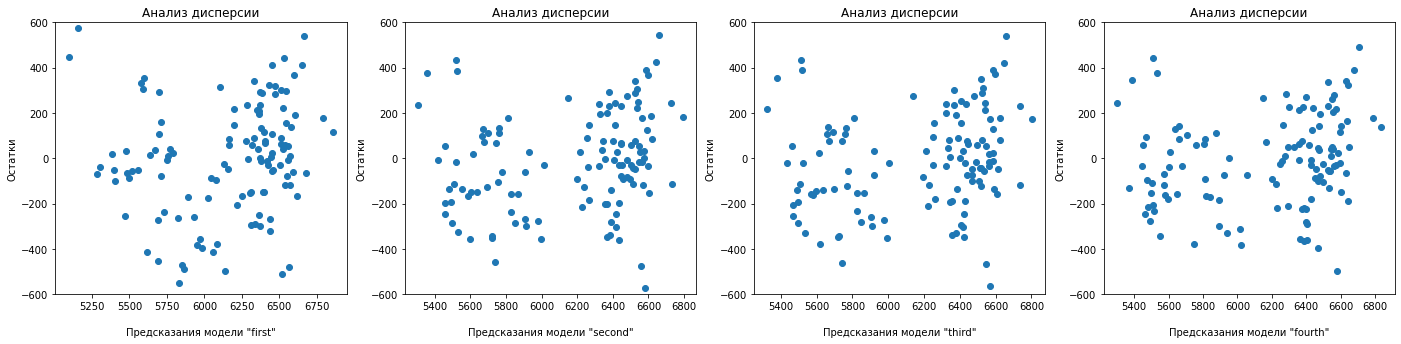

In [905]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,5))

for i in range(0, len(df_predictions.columns)):
    axes[i].scatter(df_predictions.iloc[:,i], df_residuals.iloc[:,i])
    axes[i].set_xlabel('\nПредсказания модели "{}"'.format(df_predictions.columns[i]))
    axes[i].set_ylabel('Остатки')
    axes[i].set_title('Анализ дисперсии')
    axes[i].set_ylim(-600,600)

Определим доверительный интервал прогноза модели № 4. Доверительный интервал прогноза, это интервал в котором будут находиться наши прогнозы с заданной вероятностью. Как правило, вероятность берут равной 95%. Нижней границей интервала будет 0.025 квантиль, а верхней 0.975 на предсказаниях модели.

In [906]:
df_residuals['fourth'].quantile([0.025, 0.975])

0.025   -383.419186
0.975    373.644188
Name: fourth, dtype: float64

Все модели показывают значительный коэффициент детерминации, однако анализ остатков демонстрирует сильную нестабильность результатов предсказаний. **Необходимо улучшать модель!**

Для этого целесообразно:
- Найти и добавить в модель дополнительные признаки. Скорее всего, на этапе сбора данных не учли какие-то признаки.
- Трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым.

Для дальнейшей работы примем модель № 4 с наилучшими показателями.

Доверительный интеравл предсказаний построенной модели составляет от -387.86 до 380.431.

###  Промежуточный вывод

Все модели показывают значительный коэффициент детерминации, однако анализ остатков демонстрирует сильную нестабильность результатов предсказаний. **Необходимо улучшать модель!**

Для этого целесообразно:
- Найти и добавить в модель дополнительные признаки. Скорее всего, на этапе сбора данных не учли какие-то признаки.
- Трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым.

Для дальнейшей работы примем модель № 4 с наилучшими показателями.

Доверительный интеравл предсказаний построенной модели составляет **от -373.80 до 379.53.**

### Применение модели к дата-сету с коровами, доступными к приобретению

Сформируем на основе таблицы `data_buy` таблицу для предсказания, аналогичную таблице `data_main`

In [907]:
c_data_main

,id,eke,crude_protein,sugar_protein_ratio,breed,dad_breed,age,pasture_type,fat,protein,yield,taste,sugar_protein_ratio_category,eke_power,dad_name
0,1,14.2,1743,0.890,вис бик айдиал,айдиал,более_2_лет,равнинное,3.58,3.076,5863,1,0.0,201.64,буйный
1,2,12.8,2138,0.890,вис бик айдиал,соверин,менее_2_лет,равнинное,3.54,3.079,5529,1,0.0,163.84,соловчик
2,3,14.0,1854,0.885,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.59,3.074,5810,0,0.0,196.00,барин
3,4,12.4,2012,0.885,рефлешнсоверинг,айдиал,более_2_лет,холмистое,3.40,3.075,5895,0,0.0,153.76,буйный
4,5,12.8,1675,0.885,вис бик айдиал,соверин,менее_2_лет,равнинное,3.73,3.073,5302,1,0.0,163.84,барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,625,15.4,1964,0.940,рефлешнсоверинг,айдиал,более_2_лет,равнинное,3.74,3.075,6812,0,1.0,237.16,буйный
608,626,12.9,1700,0.880,рефлешнсоверинг,соверин,менее_2_лет,равнинное,3.64,3.073,5513,1,0.0,166.41,барин
609,627,14.4,1837,0.880,рефлешнсоверинг,соверин,более_2_лет,холмистое,3.64,3.075,5970,0,0.0,207.36,барин
610,628,13.8,1994,0.890,рефлешнсоверинг,соверин,более_2_лет,равнинное,3.64,3.077,5746,1,0.0,190.44,барин


In [908]:
c_data_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079
10,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073


В связи с тем, что заказчик планирует увеличить средние значения ЭКЕ, Сырой протеин, СПО на 5% в таблицу `data_buy` внесем новые данные. И преобразуем признаки `eke_power` и `sugar_protein_ratio`

In [909]:
c_data_buy['eke'] =  c_data_main['eke'].median() * 1.05
c_data_buy['crude_protein'] =  c_data_main['crude_protein'].median() * 1.05
c_data_buy['sugar_protein_ratio'] =  c_data_main['sugar_protein_ratio'].median() * 1.05

In [910]:
def create_cat_col_buy(row):
    if row['sugar_protein_ratio'] <= 0.91:
        return 0.
    else:
        return 1.

In [911]:
c_data_buy.loc[:, 'sugar_protein_ratio_category'] = c_data_buy.apply(create_cat_col_buy, axis=1)
c_data_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein,eke,crude_protein,sugar_protein_ratio,sugar_protein_ratio_category
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,15.435,1976.1,0.9765,1.0
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,15.435,1976.1,0.9765,1.0
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,15.435,1976.1,0.9765,1.0
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,15.435,1976.1,0.9765,1.0
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,15.435,1976.1,0.9765,1.0
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,15.435,1976.1,0.9765,1.0
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,15.435,1976.1,0.9765,1.0
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,15.435,1976.1,0.9765,1.0
10,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,15.435,1976.1,0.9765,1.0
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,15.435,1976.1,0.9765,1.0


In [912]:
c_data_buy['eke_power'] =  c_data_buy['eke'] ** 2
c_data_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein,eke,crude_protein,sugar_protein_ratio,sugar_protein_ratio_category,eke_power
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,15.435,1976.1,0.9765,1.0,238.239225
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,15.435,1976.1,0.9765,1.0,238.239225
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,15.435,1976.1,0.9765,1.0,238.239225
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,15.435,1976.1,0.9765,1.0,238.239225
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,15.435,1976.1,0.9765,1.0,238.239225
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,15.435,1976.1,0.9765,1.0,238.239225
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,15.435,1976.1,0.9765,1.0,238.239225
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,15.435,1976.1,0.9765,1.0,238.239225
10,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,15.435,1976.1,0.9765,1.0,238.239225
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,15.435,1976.1,0.9765,1.0,238.239225


Обучим модель № 4.

In [913]:
good_encoder_lr, good_scyler_lr, good_result_lr = model_lr(
    c_data_main,
    goal='yield',
    num_col_names = num_col_names['fourth'],
    cat_col_names = cat_col_names['fourth'],
    out = 'model'
)

In [914]:
# Нормализуем категориальные признаки
cat_col_predict = good_encoder_lr.transform(c_data_buy[cat_col_names['fourth']])
encoder_col_names = good_encoder_lr.get_feature_names_out()
cat_col_predict = pd.DataFrame(cat_col_predict, columns=encoder_col_names)

In [915]:
# Масштабируем количественные признаки
num_col_predict = good_scyler_lr.transform(c_data_buy[num_col_names['fourth']])
num_col_predict = pd.DataFrame(num_col_predict, columns=num_col_names['fourth'])

In [916]:
# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
df_predict = pd.concat([cat_col_predict, num_col_predict], axis=1)

In [917]:
predictions_lr = good_result_lr.predict(df_predict)

In [918]:
predictions_lr

array([6597.72008671, 6545.79526498, 6277.127694  , 6621.19633171,
       6558.48275999, 6569.86037117, 6545.79526498, 6621.19633171,
       6354.28440144, 6569.86037117, 6597.72008671, 6316.07059013,
       6621.19633171, 6354.28440144, 6569.86037117, 6545.79526498])

In [919]:
c_data_buy['predict_yield'] = predictions_lr
c_data_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein,eke,crude_protein,sugar_protein_ratio,sugar_protein_ratio_category,eke_power,predict_yield
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,15.435,1976.1,0.9765,1.0,238.239225,6597.720087
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,15.435,1976.1,0.9765,1.0,238.239225,6545.795265
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,15.435,1976.1,0.9765,1.0,238.239225,6277.127694
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,15.435,1976.1,0.9765,1.0,238.239225,6621.196332
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,15.435,1976.1,0.9765,1.0,238.239225,6558.482760
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,15.435,1976.1,0.9765,1.0,238.239225,6569.860371
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,15.435,1976.1,0.9765,1.0,238.239225,6545.795265
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,15.435,1976.1,0.9765,1.0,238.239225,6621.196332
10,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,15.435,1976.1,0.9765,1.0,238.239225,6354.284401
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,15.435,1976.1,0.9765,1.0,238.239225,6569.860371


С учетом доверительного интервала выбранной модели, заказчику предлагаются к приобретению все коровы за исключением id = [2, 10, 13, 16]

### Вывод по разделу "Обучение модели линейной регрессии"

В результате проведения моделирования получены 4 модели, различающиеся метриками.

Все модели показывают значительный коэффициент детерминации, однако анализ остатков демонстрирует сильную нестабильность результатов предсказаний. Необходимо улучшать модель!

Для этого целесообразно:

Найти и добавить в модель дополнительные признаки. Скорее всего, на этапе сбора данных не учли какие-то признаки.
Трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым.

Доверительный интеравал предсказаний лучшей модели составляет от -387.86 до 380.431.

_После применения лучшей модели заказчику предлагаются к приобретению все коровы за исключением id = [2, 10, 13, 16]_

## Обучение модели логистической регрессии

Эффективность синтеза протеина микрофлорой рубца зависит от сахаро-протеинового отношения в рационе (у молочных коров в норме оно равно 1:1). При недостатке в летних рационах жвачных растворимых углеводов и повышенном содержании протеина нарушается усвоение кальция и каротина, снижаются молочность и содержание жира в молоке. Об уровне обеспеченности организма ж-ных протеином позволяет судить протеиновое отношение. На вкус молока влияет его жирность и содержание протеина. В связи с этим для прогнозирования вкуса молока предлагается использовать количественные критерии: `fat`, `proteim`, `sugar_protein_ratio`.

Не свойственные молоку вкусовые качества могут приобретаться различными способами. Самым главным фактором является корм, в том числе, трава и сено, различающееся на разных пастбищах. Признак `pasture_type` также используем в модели.

Можно говорить о том, что от породы коров может зависеть жирность, а значит и вкус. Однако, признак `fat` мы уже используем.

In [920]:
num_col_names_logr = [
    'eke',
    'crude_protein',
    'fat',
    'protein',
    'eke_power'
    
]

In [921]:
cat_col_names_logr = [
    'pasture_type',
    'breed',
    'dad_breed',
    'dad_name',
    'sugar_protein_ratio_category'
]

Обучим модель

In [922]:
X_train, X_test, y_train, y_test = (
    prepare_split(
        c_data_main,
        'taste',
        num_col_names_logr,
        cat_col_names_logr,
        val=False
    )
)

X_train, X_test, encoder, scaler = (
    prepare_data(X_train, X_test, cat_col_names_logr, num_col_names_logr)
)

# Обучаем модель
model_logr = LogisticRegression()
model_logr.fit(X_train, y_train)
predictions_log = model_logr.predict(X_test)

acc:  0.585
precision:  0.57
recall:  0.828


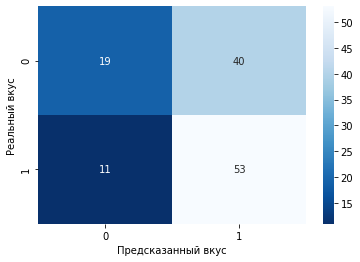

In [923]:
# Рассчитываем метрики на тестовых данных
cm, acc, recall, precision = (
    get_metrics(y_test, predictions_log, 'logistic')
)

print_logostic_metrics(cm, acc, recall, precision)

Модель показывает невысокое качество. Метрика accuracy достигает только значения 0.556.

Для разработываемой модели наиболее критичная ошибка - FP (ложно-положительная), то есть если предсказанный вкус молока будет "Вкусное" ("1"), а на самом деле молоко "Не вкусное" ("0"), то заказчик зря купит такую корову. Если молоко будет предсказано как "Не вкусное" и заказчик не купит такую корову, а молоко окажется "Вкусное" - убытков заказчику не принесет.

В связи с этим, будем снижать количество ошибок FP (59), то есть увеличивать метрику precision.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Немного изменились метрики. Исправлю вывод
</div>

<div class="alert alert-block alert-info">
<b>Изменения:</b> Были внесены изменения, представленные ниже ↓↓↓.
</div>

### Промежуточный вывод

Модель показывает невысокое качество. Метрика accuracy достигает только значения **0.562**.

Для разработываемой модели наиболее критичная ошибка - FP (ложно-положительная), то есть если предсказанный вкус молока будет "Вкусное" ("1"), а на самом деле молоко "Не вкусное" ("0"), то заказчик зря купит такую корову. Если молоко будет предсказано как "Не вкусное" и заказчик не купит такую корову, а молоко окажется "Вкусное" - убытков заказчику не принесет.

В связи с этим, будем снижать количество ошибок FP (**55**), то есть увеличивать метрику precision.

Подберем порог классификации

In [924]:
y_proba = model_logr.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

data 

,y_valid,y_proba
115,1,0.884491
62,1,0.869347
93,1,0.866699
46,1,0.866163
36,1,0.831076
...,...,...
16,0,0.282273
37,0,0.266678
80,1,0.262950
65,0,0.251220


In [925]:
def log_reg_itog_prob(model, X1, y, name):
    
    X = model.predict_proba(X1)[:,1] > 0.82
    
    accuracy   = accuracy_score(y, X)
    recall     = recall_score(y, X)
    precission = precision_score(y, X)
    
    probabilities_valid = model.predict_proba(X1)
    probabilities_one_valid = probabilities_valid[:, 1]
    data = {name : [accuracy, recall, precission]}
    df = pd.DataFrame(data, index=['Accuracy', 'Recall', 'Precission'] )
    return df.round(2)

In [926]:
log_reg_itog_prob(model_logr, X_test, y_test, 'на test')

,на test
Accuracy,0.55
Recall,0.16
Precission,0.91


Применим модель к таблице `data_buy`

In [928]:
# Нормализуем категориальные признаки
X_test_ohe = encoder.transform(c_data_buy[cat_col_names_logr])
encoder_col_names = encoder.get_feature_names_out()
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

# Масштабируем количественные признаки
X_test_scaled = scaler.transform(c_data_buy[num_col_names_logr])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names_logr)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

predictions_log = model_logr.predict_proba(X_test)[:,1]
predictions_log

array([0.79428133, 0.7091208 , 0.56231809, 0.54949939, 0.55152733,
       0.36538392, 0.6830282 , 0.77128613, 0.34933002, 0.63255429,
       0.40645459, 0.7517042 , 0.60459178, 0.67566792, 0.35420404,
       0.57015889])

Применим выявленный порог классификации

In [929]:
c_data_buy['predict_taste_p'] = predictions_log
c_data_buy['predict_taste'] = c_data_buy['predict_taste_p'].apply(lambda x: 1 if x >= ppb else 0)
c_data_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein,eke,crude_protein,sugar_protein_ratio,sugar_protein_ratio_category,eke_power,predict_yield,predict_taste_p,predict_taste
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,15.435,1976.1,0.9765,1.0,238.239225,6597.720087,0.794281,0
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.709121,0
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,15.435,1976.1,0.9765,1.0,238.239225,6277.127694,0.562318,0
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.549499,0
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,15.435,1976.1,0.9765,1.0,238.239225,6558.482760,0.551527,0
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.365384,0
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.683028,0
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.771286,0
10,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,15.435,1976.1,0.9765,1.0,238.239225,6354.284401,0.349330,0
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.632554,0


### Вывод по разделу "Обучение модели логистической регрессии"

В результате проведения моделирования получена модель, предсказывающая вкус молока. Для обучения модели выбраны признаки "Жирность", "Уровень белка", "СПО", "Тип пастбища".

Модель показывает невысокое качество. Метрика accuracy достигает только значения 0.556. Для разработываемой модели наиболее критичная ошибка - FP (ложно-положительная), то есть если предсказанный вкус молока будет "Вкусное" ("1"), а на самом деле молоко "Не вкусное" ("0"), то заказчик зря купит такую корову. Если молоко будет предсказано как "Не вкусное" и заказчик не купит такую корову, а молоко окажется "Вкусное" - убытков заказчику не принесет.

**В результате выбора порога классификации и применения модели к перечню коров, доступных к приобретению, заказчику предлагается не приобретать коров у этого поставщика.**

## Итоговый вывод

Итоговые результаты применения моделей машинного обучения

In [930]:
c_data_buy[['predict_yield', 'predict_taste']]

,predict_yield,predict_taste
0,6597.720087,0
1,6545.795265,0
2,6277.127694,0
3,6621.196332,0
4,6558.482760,0
5,6569.860371,0
7,6545.795265,0
9,6621.196332,0
10,6354.284401,0
11,6569.860371,0


В соответствии с планом работы были достигнуты следующие результаты.

**А. Изучение входных данных**

Для проведения исследования была получена выборка из 629 записей о коровах стада заказчика, о родословной каждой коробы (папа) и о коровах поставщика, которые могут быть приобретены. Можно сделать предварительный вывод, что предоставленных данных _достаточно_ для достижения цели исследования. Были выявлены некоторые проблемы с входными данными, требующие предобработки: проблемы с представлением дата-сетов, проблемы с типами данных, возможные дубликаты.

**Б. Предобработка данных**

В ходе предобработки данных не были обнаружены пропущенные значения.

Были обнаружены и обработаны полные (9 шт.) и неявные (в 2 столбцах) дубликаты. Причиной появления дубликатов может являться челевеческий фактов, приводящий к появлению полных дубликатов (посчитали нескольких коров несколько раз), а также приводящий к появлению ошибок в заполнении некоторых данных. В частности, ошибке в наименовании породы (неявный дубликат в столбце dad_breed таблицы data_main) и в типе пастбища, который по сути повторяет уже существующий ("Равнинные" при существующем "Равнинное").

Изменены типы данных в соответствии с их содержанием в столбцах с численными показателями. Сведения в них были представлены в виде строк с символами, которые не могут быть использованы при анализе и разработке моделей машинного обучения. Причиной появления данных с некорректными типами данных является принцип сбора и сохранения данных со стороны заказчика (использование запятой вместо точки в представлении дробных чисел).

**В. Результаты исследовательского анализа**

В результате проведения исследовательского анализа были выявлены ряд факторов, влияющих на достижение цели исследования.

В результате исследования категориальных признаков дата-сетов выявлено, в основном, равномерное распределение данных для обучения по бинарным признакам (соотношение около 1:1). Только один признак («возраст») имеет соотношение 2:8, что может оказаться недостаточным для достижения целей работы. Малое количество элементов одного типа может сказаться на результатах работы моделей машинного обучения. Возможность использования указанного признака для обучения моделей необходимо оценить отдельно. Мультиклассовый признак "Имя папы" используем при обучении моделей отдельно.

В результате исследования количественных параметров дата-сетов выявлен выброс в столбце yield таблицы data_main, в 7 раз превышающий медиану. Выброс удален. Также обнаружено большое количество выбросов вниз в столбце fat таблицы data_main. В случае удаления мы теряем для анализа и дальнейшего обучения значительное количество показателей признака. Все значения были сохранены и их влияние на модель незначительно.

**Г. Обучение и применение модели линейной регрессии**

В результате проведения моделирования получены 4 модели, различающиеся метриками. Все модели показывают значительный коэффициент детерминации, однако анализ остатков демонстрирует сильную нестабильность результатов предсказаний. Необходимо улучшать модель!

Для этого целесообразно найти и добавить в модель дополнительные признаки. Скорее всего, на этапе сбора данных не учли какие-то признаки. Кроме того, имеет смысл трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым.

Доверительный интеравал предсказаний лучшей модели составляет от <del>-387.86 до 380.431</del> -373.80 до 379.53. После применения лучшей модели заказчику предлагаются к приобретению все коровы за исключением id = [2, 10, 13, 16]

**Д. Обучение и применение модели логистической регрессии**

В результате проведения моделирования получена модель, предсказывающая вкус молока. Модель показывает невысокое качество.

Метрика accuracy достигает только значения 0.556. Для разработываемой модели наиболее критичная ошибка - FP (ложно-положительная), то есть если предсказанный вкус молока будет "Вкусное" ("1"), а на самом деле молоко "Не вкусное" ("0"), то заказчик зря купит такую корову. Если молоко будет предсказано как "Не вкусное" и заказчик не купит такую корову, а молоко окажется "Вкусное" - убытков заказчику не принесет.

В результате выбора порога классификации и применения модели к перечню коров, доступных к приобретению, заказчику предлагается не приобретать коров у этого поставщика.

**Е. Достижение цели исследования**

Таким образом, в результате исследования заказчику рекомендовано сформировать дополнительные признаки коров, доступных к приобретению. Например, признак "Возраст", поскольку для стада заказчика данный признак доступен для применения в обучении модели, а для коров поставщика - нет.

**Цель исследования достинута - на основании исходных данных с использованием моделей машинного обучения рекомендовано заказчику не приобретать коров до проведения дополнительного исследования.**

# Дополнение к работе в связи с вновь добавленными данными

## Корректировка исходных данных для прогнозирования

In [931]:
try:
    data_buy2 = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=";")
except Exception as e: print(e)     

In [932]:
c_data_buy['age'] = data_buy2['Возраст']

In [933]:
c_data_buy = c_data_buy.rename(
    columns = {
        'predict_yield': 'predict_yield_before',
        'predict_taste_p': 'predict_taste_p_before',
        'predict_taste': 'predict_taste_before',
    }
)
c_data_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein,eke,crude_protein,sugar_protein_ratio,sugar_protein_ratio_category,eke_power,predict_yield_before,predict_taste_p_before,predict_taste_before,age
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,15.435,1976.1,0.9765,1.0,238.239225,6597.720087,0.794281,0,более_2_лет
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.709121,0,менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,15.435,1976.1,0.9765,1.0,238.239225,6277.127694,0.562318,0,более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.549499,0,более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,15.435,1976.1,0.9765,1.0,238.239225,6558.482760,0.551527,0,более_2_лет
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.365384,0,менее_2_лет
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.683028,0,более_2_лет
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.771286,0,менее_2_лет
10,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,15.435,1976.1,0.9765,1.0,238.239225,6354.284401,0.349330,0,более_2_лет
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.632554,0,более_2_лет


## Обучение модели линейной регрессии № 5 с выводом метрик с учетом новых данных

MAE = 155
MSE = 41630
RMSE = 204
R2 LinearRegression = 0.8316447020059157


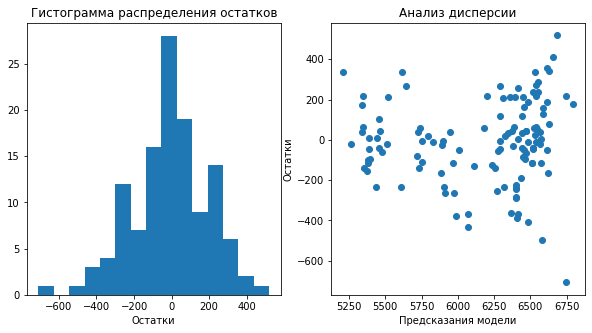

In [934]:
num_col_names['fifth'] = list(num_col_names['fourth'])


cat_col_names['fifth'] = list(cat_col_names['fourth'])
cat_col_names['fifth'].append('age')

metrics['fifth'], residuals['fifth'], predictions['fifth'] = model_lr(
    c_data_main,
    goal='yield',
    num_col_names = num_col_names['fifth'],
    cat_col_names = cat_col_names['fifth']
)


## Сравнение моделей линейной регресии

Проведем анализ показателей метрик для всех обученных моделей. Сведем все метрики, остатки и предсказания в единые таблицы. Построим графики и сделаем выводы.

In [935]:
df_metrics = pd.DataFrame(metrics).apply(lambda x: np.round(x, decimals=2))
df_metrics

,first,second,third,fourth,fifth
mae,193.71,178.53,179.71,166.82,155.38
mse,62000.19,50584.04,50634.75,44602.35,41629.84
rmse,249.00,224.91,225.02,211.19,204.03
r2_lr,0.75,0.80,0.80,0.82,0.83


In [936]:
df_residuals = pd.DataFrame(residuals)
df_residuals

,first,second,third,fourth,fifth
81,-53.976762,-114.884597,-121.776939,-132.727218,-116.545360
218,282.383047,220.310205,213.950651,202.599624,216.709246
55,-414.568753,-266.823613,-261.312314,-34.934356,-111.913949
600,-30.545378,-83.853177,-73.357102,-102.890168,-114.946228
264,-415.211173,-324.394854,-331.742383,-344.174582,-232.411438
...,...,...,...,...,...
530,-0.574174,-91.023480,-101.231605,-99.682030,-95.762284
529,7.433257,29.117141,33.614001,74.450634,64.432540
118,235.421914,228.756592,235.143616,225.830521,212.592046
79,-150.144391,-196.066769,-190.487130,72.430048,59.532113


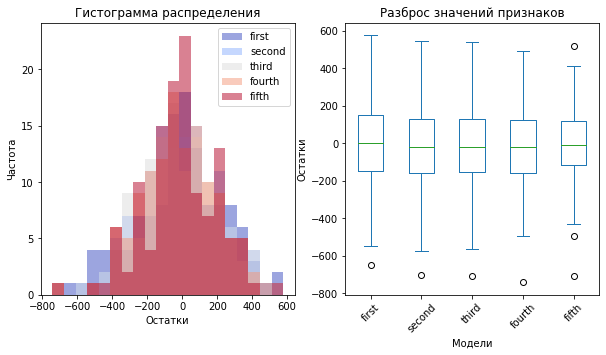

-------

Распределение остатков модели "first"

Ключевые характеристики распределения:
count     123.00
mean       -8.64
std       249.87
min      -652.58
25%      -150.95
50%        -0.57
75%       151.58
max       576.44
Name: first, dtype: object
-------

Распределение остатков модели "second"

Ключевые характеристики распределения:
count     123.00
mean      -19.92
std       224.94
min      -701.34
25%      -157.88
50%       -18.02
75%       128.62
max       543.74
Name: second, dtype: object
-------

Распределение остатков модели "third"

Ключевые характеристики распределения:
count     123.00
mean      -20.17
std       225.03
min      -709.45
25%      -155.97
50%       -21.68
75%       130.79
max       541.65
Name: third, dtype: object
-------

Распределение остатков модели "fourth"

Ключевые характеристики распределения:
count     123.00
mean      -17.47
std       211.33
min      -741.85
25%      -158.38
50%       -23.15
75%       121.44
max       492.93
Name: fourth, dtype: obj

In [937]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

df_residuals.plot(kind='hist', bins=20, ax=axes[0], alpha=0.5, cmap='coolwarm')
axes[0].set_title('Гистограмма распределения')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частота')
df_residuals.plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
axes[1].set_xlabel('Модели')
axes[1].set_ylabel('Остатки')

plt.show()

for item in df_residuals:
    print('-------')
    print()
    print('Распределение остатков модели "{}"'.format(item))
    my_describe(df_residuals, item, desc=['describe'])

In [938]:
df_predictions = pd.DataFrame(predictions)
df_predictions

,first,second,third,fourth,fifth
0,6451.976762,6512.884597,6519.776939,6530.727218,6514.545360
1,6472.616953,6534.689795,6541.049349,6552.400376,6538.290754
2,6057.568753,5909.823613,5904.312314,5677.934356,5754.913949
3,6425.545378,6478.853177,6468.357102,6497.890168,6509.946228
4,5619.211173,5528.394854,5535.742383,5548.174582,5436.411438
...,...,...,...,...,...
118,6368.574174,6459.023480,6469.231605,6467.682030,6463.762284
119,6444.566743,6422.882859,6418.385999,6377.549366,6387.567460
120,6369.578086,6376.243408,6369.856384,6379.169479,6392.407954
121,6390.144391,6436.066769,6430.487130,6167.569952,6180.467887


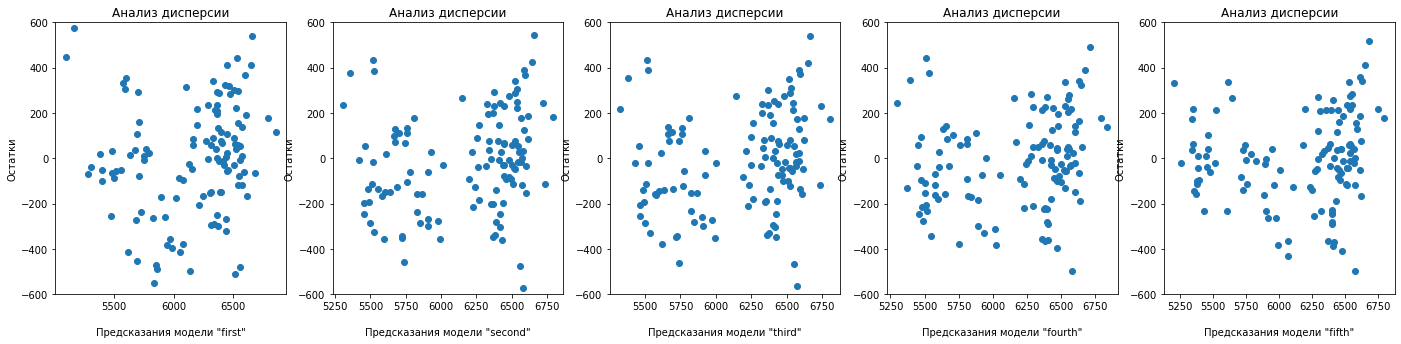

In [939]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24,5))

for i in range(0, len(df_predictions.columns)):
    axes[i].scatter(df_predictions.iloc[:,i], df_residuals.iloc[:,i])
    axes[i].set_xlabel('\nПредсказания модели "{}"'.format(df_predictions.columns[i]))
    axes[i].set_ylabel('Остатки')
    axes[i].set_title('Анализ дисперсии')
    axes[i].set_ylim(-600,600)

Характеристики модели улучшились. Можно ее применить к новым данным.

Определим доверительный интервал прогноза модели № 5.

In [940]:
df_residuals['fifth'].quantile([0.025, 0.975])

0.025   -407.093879
0.975    341.092362
Name: fifth, dtype: float64

## Применение модели к дата-сету с коровами, доступными к приобретению

Обучим модель № 5 с возвращением функцией объектов encoder, scyler и model

In [941]:
last_encoder_lr, last_scyler_lr, last_result_lr = model_lr(
    c_data_main,
    goal='yield',
    num_col_names = num_col_names['fifth'],
    cat_col_names = cat_col_names['fifth'],
    out = 'model'
)

In [942]:
# Нормализуем категориальные признаки
cat_col_predict = last_encoder_lr.transform(c_data_buy[cat_col_names['fifth']])
encoder_col_names = last_encoder_lr.get_feature_names_out()
cat_col_predict = pd.DataFrame(cat_col_predict, columns=encoder_col_names)

In [943]:
# Масштабируем количественные признаки
num_col_predict = last_scyler_lr.transform(c_data_buy[num_col_names['fifth']])
num_col_predict = pd.DataFrame(num_col_predict, columns=num_col_names['fifth'])

In [944]:
# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
df_predict = pd.concat([cat_col_predict, num_col_predict], axis=1)

In [945]:
predictions_lr = last_result_lr.predict(df_predict)

In [946]:
predictions_lr

array([6589.08847731, 6326.62626613, 6290.43108856, 6605.42238995,
       6545.49525081, 6349.84821625, 6553.56604131, 6378.48261477,
       6370.37163966, 6576.78799143, 6589.08847731, 6103.64052113,
       6605.42238995, 6370.37163966, 6349.84821625, 6553.56604131])

In [947]:
c_data_buy['predict_yield_after'] = predictions_lr
c_data_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein,eke,crude_protein,sugar_protein_ratio,sugar_protein_ratio_category,eke_power,predict_yield_before,predict_taste_p_before,predict_taste_before,age,predict_yield_after
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,15.435,1976.1,0.9765,1.0,238.239225,6597.720087,0.794281,0,более_2_лет,6589.088477
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.709121,0,менее_2_лет,6326.626266
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,15.435,1976.1,0.9765,1.0,238.239225,6277.127694,0.562318,0,более_2_лет,6290.431089
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.549499,0,более_2_лет,6605.422390
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,15.435,1976.1,0.9765,1.0,238.239225,6558.482760,0.551527,0,более_2_лет,6545.495251
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.365384,0,менее_2_лет,6349.848216
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.683028,0,более_2_лет,6553.566041
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.771286,0,менее_2_лет,6378.482615
10,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,15.435,1976.1,0.9765,1.0,238.239225,6354.284401,0.349330,0,более_2_лет,6370.371640
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.632554,0,более_2_лет,6576.787991


С учетом доверительного интервала выбранной модели, определим коров, которые заказчику предлагаются к приобретению.

In [948]:
def return_reccomend_by_yield(row):
    if (row['predict_yield_after'] + df_residuals['fifth'].quantile([0.025])[0.025]) >= 6000:
        return 1
    else:
        return 0

In [949]:
c_data_buy.loc[:, 'recomend_by_yield'] = c_data_buy.apply(return_reccomend_by_yield, axis=1)
c_data_buy[['predict_yield_before', 'predict_yield_after', 'recomend_by_yield']]

,predict_yield_before,predict_yield_after,recomend_by_yield
0,6597.720087,6589.088477,1
1,6545.795265,6326.626266,0
2,6277.127694,6290.431089,0
3,6621.196332,6605.422390,1
4,6558.482760,6545.495251,1
5,6569.860371,6349.848216,0
7,6545.795265,6553.566041,1
9,6621.196332,6378.482615,0
10,6354.284401,6370.371640,0
11,6569.860371,6576.787991,1


Предлагаются к приобретению коровы с id=[0, 3, 4, 7, 11, 12, 15, 18]

## Обучение и применение модели логистической регрессии с учетом новых данных

In [950]:
num_col_names_logr = [
    'fat',
    'protein',
    'crude_protein',
    'eke_power',
    'eke'
]

In [951]:
cat_col_names_logr = [
    'pasture_type',
    'breed',
    'dad_breed',
    'dad_name',
    'sugar_protein_ratio_category',
    'age'
]

Обучим модель

In [952]:
X_train, X_test, y_train, y_test = (
    prepare_split(
        c_data_main,
        'taste',
        num_col_names_logr,
        cat_col_names_logr,
        val=False
    )
)

X_train, X_test, encoder, scaler = (
    prepare_data(X_train, X_test, cat_col_names_logr, num_col_names_logr)
)

# Обучаем модель
model_logr = LogisticRegression()
model_logr.fit(X_train, y_train)
predictions_log = model_logr.predict(X_test)

acc:  0.585
precision:  0.57
recall:  0.828


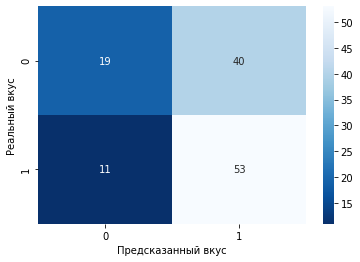

In [953]:
# Рассчитываем метрики на тестовых данных
cm, acc, recall, precision = (
    get_metrics(y_test, predictions_log, 'logistic')
)

print_logostic_metrics(cm, acc, recall, precision)

Модель показывает качество выше. Метрика accuracy достигла значения **0.582** (было 0.562).

Будем снижать количество ошибок FP (**54**), то есть увеличивать метрику precision.

Подберем порог классификации

In [954]:
y_proba = model_logr.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

data

,y_valid,y_proba
115,1,0.883087
62,1,0.871007
93,1,0.866269
46,1,0.865899
36,1,0.830536
...,...,...
16,0,0.277677
80,1,0.265474
37,0,0.258576
65,0,0.244581


In [998]:
data.head(20)

,y_valid,y_proba,y_pred
115,1,0.883087,1
62,1,0.871007,1
93,1,0.866269,0
46,1,0.865899,0
36,1,0.830536,0
64,1,0.829291,0
40,1,0.822616,0
112,1,0.821711,0
89,1,0.821173,0
8,1,0.819452,0


Positive probably:  0.88
precision:  1.0
acc:  0.496
recall:  0.031


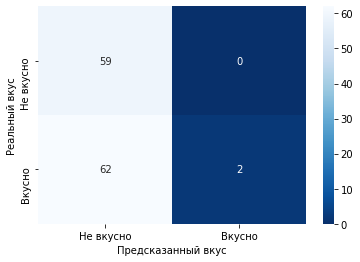

In [955]:
precision = 0.
i = 0.1
while precision < 1.0:
    data['y_pred'] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
    precision = precision_score(y_test, data['y_pred'])
    i += 0.01

ppb = i

print('Positive probably: ', round(ppb, 3))

print('precision: ',round(precision, 3))

acc = accuracy_score(y_test, data['y_pred'])
recall = recall_score(y_test, data['y_pred'])

print('acc: ',round(acc, 3))
print('recall: ',round(recall, 3))

cm = confusion_matrix(y_test, data['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r',
            yticklabels=['Не вкусно','Вкусно'],
            xticklabels=['Не вкусно','Вкусно']).set(xlabel='Предсказанный вкус', ylabel='Реальный вкус')
plt.show()

Изменился порог классификации. Интересно, как он повлияет на применение модели к основным данным. Теперь порог классификации - 0.869

Применим модель к таблице `data_buy`

In [956]:
# Нормализуем категориальные признаки
X_test_ohe = encoder.transform(c_data_buy[cat_col_names_logr])
encoder_col_names = encoder.get_feature_names_out()
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

# Масштабируем количественные признаки
X_test_scaled = scaler.transform(c_data_buy[num_col_names_logr])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names_logr)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

predictions_log = model_logr.predict_proba(X_test)[:,1]
predictions_log

array([0.79414277, 0.69537877, 0.56500901, 0.54922211, 0.55079649,
       0.34607643, 0.68558133, 0.75837692, 0.34752381, 0.63287222,
       0.40133173, 0.73976667, 0.60482168, 0.67666094, 0.33367448,
       0.57448908])

Применим выявленный порог классификации

In [957]:
c_data_buy['predict_taste_p_after'] = predictions_log
c_data_buy['predict_taste_after'] = c_data_buy['predict_taste_p_after'].apply(lambda x: 1 if x >= ppb else 0)
c_data_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein,eke,crude_protein,sugar_protein_ratio,sugar_protein_ratio_category,eke_power,predict_yield_before,predict_taste_p_before,predict_taste_before,age,predict_yield_after,recomend_by_yield,predict_taste_p_after,predict_taste_after
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,15.435,1976.1,0.9765,1.0,238.239225,6597.720087,0.794281,0,более_2_лет,6589.088477,1,0.794143,0
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.709121,0,менее_2_лет,6326.626266,0,0.695379,0
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,15.435,1976.1,0.9765,1.0,238.239225,6277.127694,0.562318,0,более_2_лет,6290.431089,0,0.565009,0
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.549499,0,более_2_лет,6605.422390,1,0.549222,0
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,15.435,1976.1,0.9765,1.0,238.239225,6558.482760,0.551527,0,более_2_лет,6545.495251,1,0.550796,0
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.365384,0,менее_2_лет,6349.848216,0,0.346076,0
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.683028,0,более_2_лет,6553.566041,1,0.685581,0
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.771286,0,менее_2_лет,6378.482615,0,0.758377,0
10,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,15.435,1976.1,0.9765,1.0,238.239225,6354.284401,0.349330,0,более_2_лет,6370.371640,0,0.347524,0
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.632554,0,более_2_лет,6576.787991,1,0.632872,0


И, тем не менее, в результате заказчику предлагаются НЕ преобретать коров с учетом признака "Вкус молока" или изменить свою методику определения вкуса!

In [958]:
c_data_buy['recomend_by_taste'] = c_data_buy['predict_taste_after'].apply(lambda x: 1 if x == 1 else 0)
c_data_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein,eke,crude_protein,sugar_protein_ratio,sugar_protein_ratio_category,eke_power,predict_yield_before,predict_taste_p_before,predict_taste_before,age,predict_yield_after,recomend_by_yield,predict_taste_p_after,predict_taste_after,recomend_by_taste
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,15.435,1976.1,0.9765,1.0,238.239225,6597.720087,0.794281,0,более_2_лет,6589.088477,1,0.794143,0,0
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.709121,0,менее_2_лет,6326.626266,0,0.695379,0,0
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,15.435,1976.1,0.9765,1.0,238.239225,6277.127694,0.562318,0,более_2_лет,6290.431089,0,0.565009,0,0
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.549499,0,более_2_лет,6605.422390,1,0.549222,0,0
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,15.435,1976.1,0.9765,1.0,238.239225,6558.482760,0.551527,0,более_2_лет,6545.495251,1,0.550796,0,0
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.365384,0,менее_2_лет,6349.848216,0,0.346076,0,0
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,15.435,1976.1,0.9765,1.0,238.239225,6545.795265,0.683028,0,более_2_лет,6553.566041,1,0.685581,0,0
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,15.435,1976.1,0.9765,1.0,238.239225,6621.196332,0.771286,0,менее_2_лет,6378.482615,0,0.758377,0,0
10,вис бик айдиал,холмистое,соверин,соловчик,3.73,3.055,15.435,1976.1,0.9765,1.0,238.239225,6354.284401,0.349330,0,более_2_лет,6370.371640,0,0.347524,0,0
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,15.435,1976.1,0.9765,1.0,238.239225,6569.860371,0.632554,0,более_2_лет,6576.787991,1,0.632872,0,0


# Итоговый вывод

Итоговые результаты применения моделей машинного обучения

In [959]:
c_data_buy[['recomend_by_yield', 'recomend_by_taste']]

,recomend_by_yield,recomend_by_taste
0,1,0
1,0,0
2,0,0
3,1,0
4,1,0
5,0,0
7,1,0
9,0,0
10,0,0
11,1,0


В соответствии с рекомендацией заказчиком для коров поставщика был определен дополнительный признак, модели повторно обучены и получены следующие результаты.

**А. Обучение и применение модели линейной регрессии**

Доверительный интервал предсказаний модели с учетом новых данных составляет от -383.34 до 349.45 (было от -373.80 до 379.53). После применения лучшей модели заказчику предлагаются к приобретению коровы с id=[0, 3, 4, 7, 11, 12, 15, 18] (было - все коровы за исключением id = [2, 10, 13, 16])

**Б. Обучение и применение модели логистической регрессии**

В результате проведения моделирования получена модель, предсказывающая вкус молока. Модель показала улучшение качетсва - метрика accuracy достигла значения 0.582 (было 0.562).

И, тем не менее, в результате заказчику предлагаются НЕ преобретать коров с учетом признака "Вкус молока".

**Е. Достижение цели исследования**

Таким образом, в результате исследования заказчику рекомендованы к приобретению коровы с [0, 3, 4, 7, 11, 12, 15, 18] по признаку "Удой", который связан с объективными признаками коров.

А также заказчику рекомендовано изменить свою методику определения вкуса молока, либо не приобретать коров. **Вероятно, его личная методика определения вкусна молока не связана с объективными признаками коров, а носит сугубо субъективный характер.**

Цель исследования частично достинута - на основании исходных данных с использованием моделей машинного обучения рекомендовано заказчику приобретение коров, удовлетворяющих его критерию по удою коров. Однако по критерию "Вкус молока" таких коров определить не удается.